In [1]:
%run ~/.python/init.ipynb

In [2]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import PIL

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# import wandb
# import pandas as pd
# api = wandb.Api()

# # best classifier
# run = api.run("vadmas/carla-regressor/3twylpla")
# for file in run.files():
#     if file.name == 'model_best.pth':
#         print(file.name)
#         file.download(root='./models/3twylpla', replace=True)
        
# # best regressor
# run = api.run("vadmas/carla-regressor/vabn44eq")
# for file in run.files():
#     if file.name == 'model_best.pth':
#         print(file.name)
#         file.download(root='./models/vabn44eq', replace=True)

# root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/train_test_splits/carla-no-traffic/')
# df = pd.read_csv(root/"video_test.csv", index_col=0)

In [5]:
def get_cell(target):
    count, _, _ = np.histogram2d([target[0]], [target[1]], bins=10, range=[[-10,400], [-10,400]])
    cell = count.flatten().nonzero()[0]
    return cell

def read_gif(filename):
    """ readGif(filename, asNumpy=True)
    
    Read images from an animated GIF file.  Returns a list of numpy 
    arrays, or, if asNumpy is false, a list if PIL images.
    
    """
    # Load file using PIL
    pilIm = PIL.Image.open(filename)    
    pilIm.seek(0)
    
    # Read all images inside
    images = []
    try:
        while True:
            # Get image as numpy array
            tmp = pilIm.convert() # Make without palette
            a = np.asarray(tmp)
            if len(a.shape)==0:
                raise MemoryError("Too little memory to convert PIL image to array")
            # Store, and next
            images.append(a)
            pilIm.seek(pilIm.tell()+1)
    except EOFError:
        pass
    
    # Done
    return images 

class GIFDataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        # load all images in gif
        self.imgs = read_gif(path)

    def __getitem__(self, idx):
        # load images and masks         
        img = self.imgs[idx].copy()
        print(img.shape)
        if self.transforms is not None:
            img = self.transforms(img)
        return img

    def __len__(self):
        return len(self.imgs)

class CARLADataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = torch.load(root).numpy()
#         self.target = np.load(root
#                               .replace("carla-no-traffic/video","carla-no-traffic/coords")
#                               .replace(".pt",'.npy'))

    def __getitem__(self, idx):
        # load images and masks         
        img = self.imgs[idx]
#         target = self.target[idx]

        # use x,y only
#         target = target[[0,1]]
        
#         cell = get_cell(target)

        if self.transforms is not None:
            img = self.transforms(img)

        return img 
#         return img, target, cell

    def __len__(self):
        return len(self.imgs)

class SamplesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = np.moveaxis(np.load(self.root), 1,3).astype(np.uint8)
        
    def __getitem__(self, idx):
        # load images and masks         
        img = self.imgs[idx].copy()
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.imgs)
        
    
def make_data(path):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )

    print(path)
    return torch.utils.data.DataLoader(
        CARLADataset(path, data_transform),
        batch_size=64,
        shuffle=False,
        num_workers=2) 

def make_gif_data(path):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    print(path)
    return torch.utils.data.DataLoader(
            GIFDataset(path, data_transform),
            batch_size=64,
            shuffle=False,
            num_workers=2) 

def make_samples_data(path):
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    print(path)
    return torch.utils.data.DataLoader(
            SamplesDataset(path, data_transform),
            batch_size=64,
            shuffle=False,
            num_workers=2) 

class MultiHeadResNet152(nn.Module):
    def __init__(self):
        super(MultiHeadResNet152, self).__init__()
        self.resnet = torchvision.models.resnet152(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        # one for each cell
        self.regressors = nn.ModuleList([nn.Linear(in_features, 2) for i in range(100)])

    def forward(self, inputs, cells):
        emb = self.resnet(inputs)
        coords = []
        for idx, cell in enumerate(cells):
            coords.append(self.regressors[cell](emb[idx]))
        coords = torch.stack(coords)
        return coords

def load_regressor(path):
    model = MultiHeadResNet152()
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model

def load_classifier(path):
    model = torchvision.models.resnet152(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 100)
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(12,24))
    ax.imshow(inp, interpolation='nearest')
    plt.tight_layout()
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def predict_trajectory(path):
    dataset = make_data(path)
    outputs = []
    probs = []
    for idx, inputs in enumerate(dataset):
        inputs = inputs.to(device)
        with torch.no_grad():
            emb = classifier(inputs)
            prob = torch.softmax(emb, dim=1)
            prob, cell = torch.max(prob, 1)
            coords = regressor(inputs, cell)
            out = coords.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
        outputs.append(out)
        probs.append(prob)

    outputs = np.vstack(outputs)
    probs = np.concatenate(probs)
    return outputs, probs

# def predict_trajectory(path):
#     dataset = make_data(path)
#     outputs, labels = [], []
#     cells_gt, cells_pred = [], []
#     for inputs, label, cell_gt in dataset:
#         inputs = inputs.to(device)
#         with torch.no_grad():
#             emb = classifier(inputs)
#             _, cell = torch.max(emb, 1)
#             coords = regressor(inputs, cell)
#             out = coords.cpu().detach().numpy()
#         outputs.append(out)
#         labels.append(label.numpy())
#         cells_pred.append(cell.cpu().numpy())
#         cells_gt.append(cell_gt.numpy())

#     outputs = np.vstack(outputs)
#     labels = np.vstack(labels)
#     cells_gt = np.vstack(cells_gt)
#     cells_pred = np.vstack(cells_pred)
#     return outputs, labels, cells_pred.flatten(), cells_gt.flatten()


def predict_gif_trajectory(path):
    dataset = make_gif_data(path)
    outputs = []
    probs = []
    for idx, inputs in enumerate(dataset):
        inputs = inputs.to(device)
        with torch.no_grad():
            emb = classifier(inputs)
            prob = torch.softmax(emb, dim=1)
            prob, cell = torch.max(prob, 1)
            coords = regressor(inputs, cell)
            out = coords.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
        outputs.append(out)
        probs.append(prob)

    outputs = np.vstack(outputs)
    probs = np.concatenate(probs)
    return outputs, probs

def predict_sample_trajectory(path):
    dataset = make_samples_data(path)
    outputs = []
    probs = []
    for idx, inputs in enumerate(dataset):
        inputs = inputs.to(device)
        with torch.no_grad():
            emb = classifier(inputs)
            prob = torch.softmax(emb, dim=1)
            prob, cell = torch.max(prob, 1)
            coords = regressor(inputs, cell)
            out = coords.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
        outputs.append(out)
        probs.append(prob)

    outputs = np.vstack(outputs)
    probs = np.concatenate(probs)
    return outputs, probs

In [6]:
regressor = load_regressor('./models/vabn44eq/model_best.pth')
classifier = load_classifier('./models/3twylpla/model_best.pth')

In [33]:
tmp = np.load("/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_hierarchy-2/video_80.npy")

In [34]:
# drange=[0,1]
# img_batch = tmp.transpose([0, 2, 3, 1])
# # img_batch = (img_batch - drange[0]) / (drange[1] - drange[0])  * 255 # img_batch with pixel values in [0, 255]
# img_batch = img_batch.astype(np.uint8)
# imgs =  [PIL.Image.fromarray(img) for img in img_batch]

In [35]:
# imgs[300]

In [36]:
# data = make_samples_data(path)

In [37]:
# path = "/ubc/cs/research/plai-scratch/video-diffusion-shared/results-carla-final/2mtsk9sv/ema_0.9999_550000/adaptive-hierarchy-2_20_10_None_36/samples/sample_0000-0.npy"
# inputs = next(iter(data))
# inputs = inputs.transpose(1, 3)
# out = torchvision.utils.make_grid(inputs)
# imshow(out)

In [15]:
# root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/results-carla-final/2mtsk9sv/ema_0.9999_550000/')
# paths = sorted(root.glob("*/samples/*.npy"))
root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/')
paths = sorted(root.glob("video*.npy"))
for inpath in paths:
    outpath = Path(str(inpath).replace('carla_80_autoreg','carla_80_autoreg_predictions'))
    outpath_root = Path(*outpath.parts[:-1])
    outpath_root.mkdir(parents=True, exist_ok=True)
    outputs, prob = predict_sample_trajectory(inpath)
    np.save(outpath, outputs)
    

/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_0.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_1.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_10.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_11.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_12.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_13.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_14.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_15.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_16.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_17.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared

/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_88.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_89.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_9.npy
/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_90.npy


In [17]:
root = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/')
sorted(root.glob("*"))

[PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_0.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_1.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_10.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_11.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_12.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_13.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_14.npy'),
 PosixPath('/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg_predictions/video_15.npy'),
 PosixPath('/ubc/cs/resear

/ubc/cs/research/plai-scratch/video-diffusion-shared/long-videos/carla_80_autoreg/video_13.npy


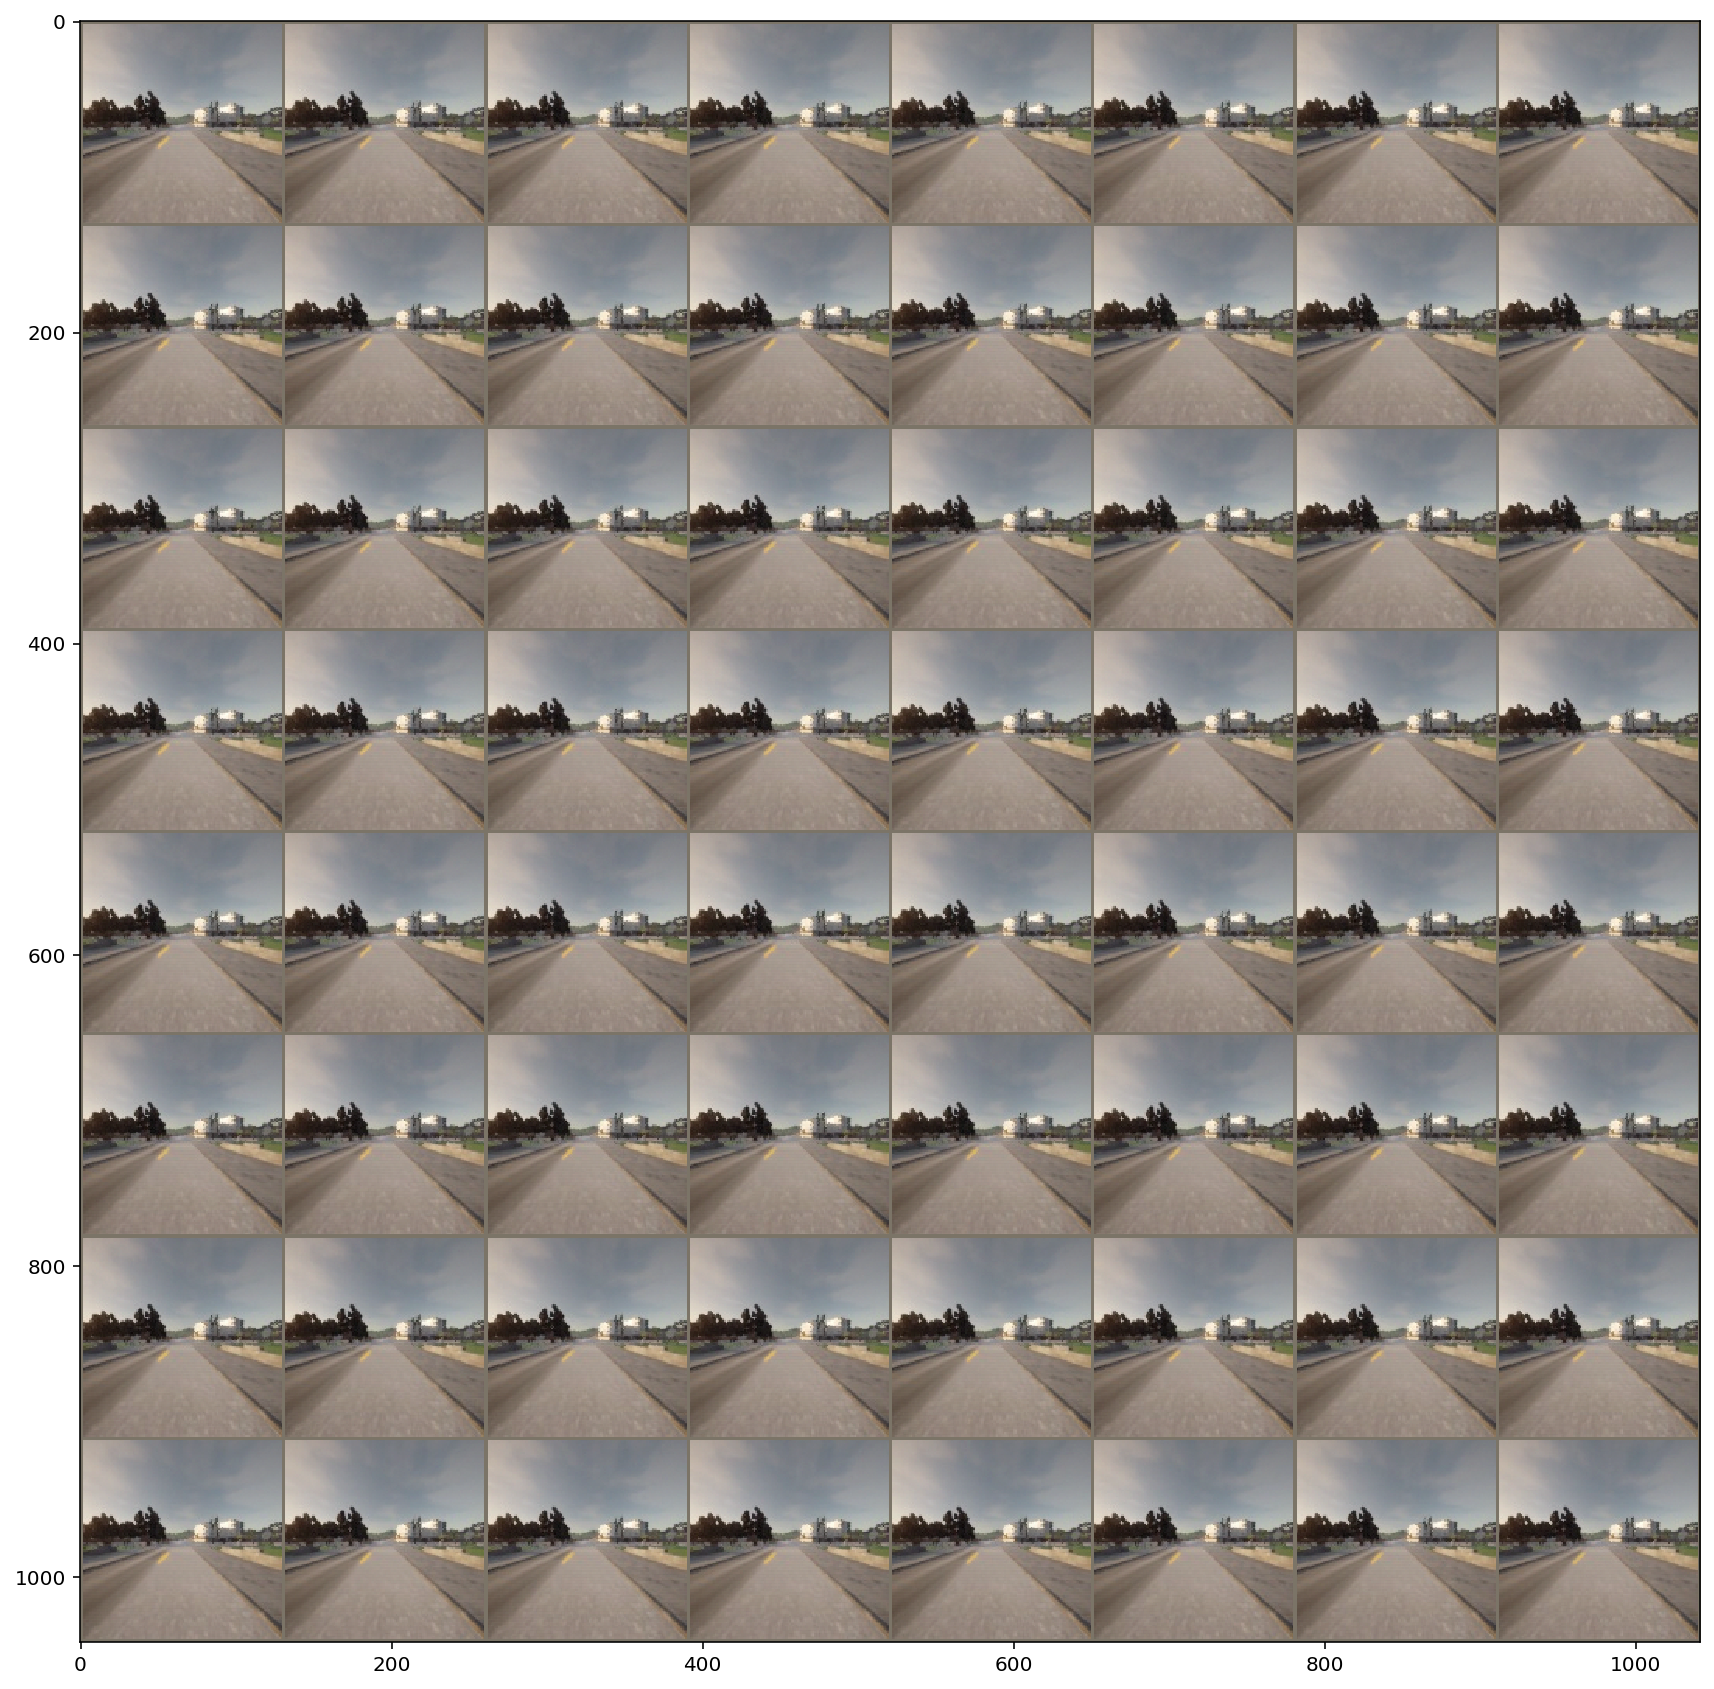

In [14]:
inpath = paths[5]
dataset = make_samples_data(inpath)
inputs = next(iter(dataset))
# inputs = inputs.transpose(1, 3)
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [121]:
# # path = df.iloc[0,0]
# path = './sampled_videos/first-1000-frame-video.gif'
# data = make_gif_data(path)
# img = next(iter(data))
# # img = img.to(device)
# # emb = classifier(img)
# out = torchvision.utils.make_grid(img)
# imshow(out)

In [146]:
path = Path('/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/')
paths = sorted(path.glob("*.pt"))
for inpath in paths:
#     print(inpath)
    outpath = Path(str(inpath).replace('.pt','_prediction.npy'))
    outputs, prob = predict_trajectory(inpath)
    np.save(outpath, outputs)
    

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_0.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_1.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_10.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_100.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_101.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_102.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_103.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_104.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_105.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_106.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_195.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_196.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_197.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_198.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_199.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_2.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_20.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_200.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_201.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_202.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/vide

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_276.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_277.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_278.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_279.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_28.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_280.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_281.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_282.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_283.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_284.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/vi

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_357.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_358.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_359.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_36.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_360.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_361.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_362.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_363.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_364.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_365.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/vi

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_440.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_441.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_442.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_443.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_444.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_445.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_446.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_447.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_448.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_449.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/v

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_526.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_527.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_528.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_529.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_53.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_530.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_531.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_532.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_54.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_55.pt
/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/vide

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_425.pt


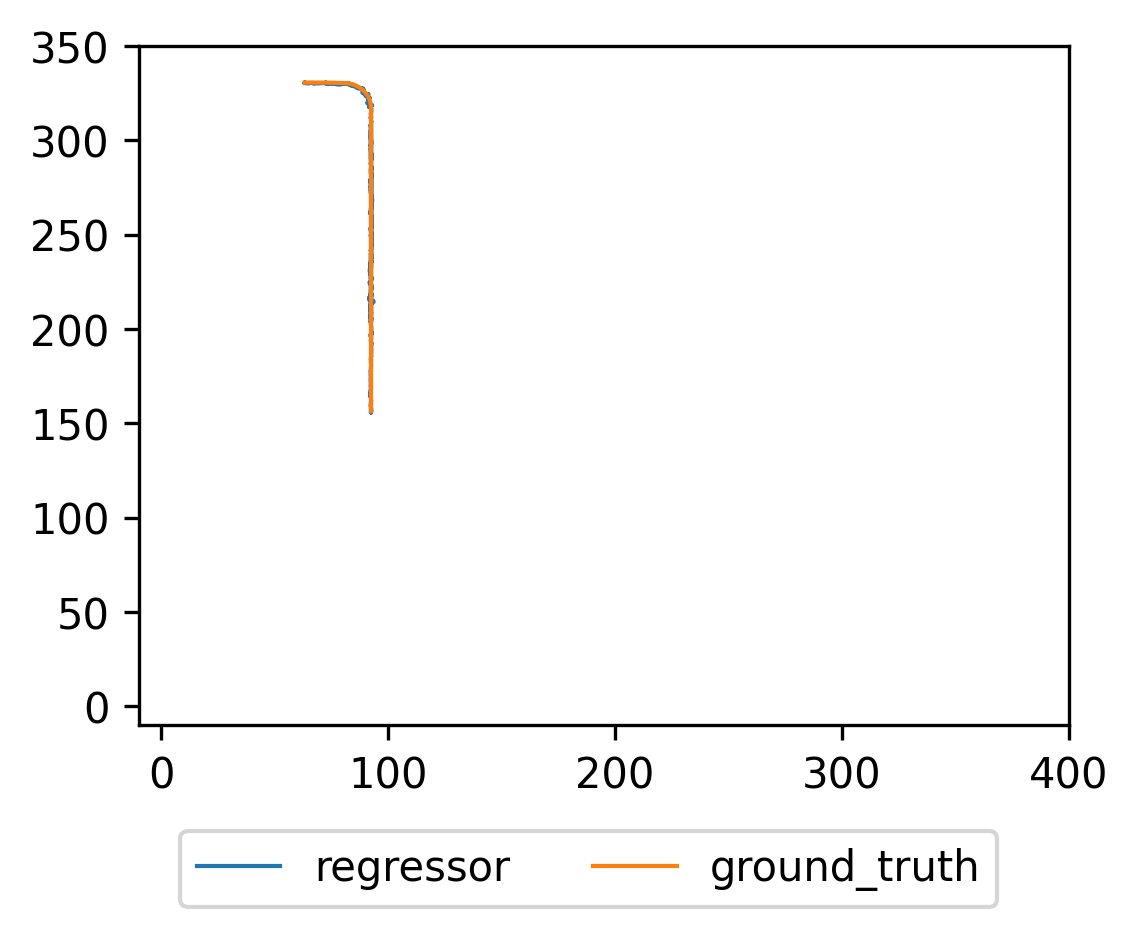

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_426.pt


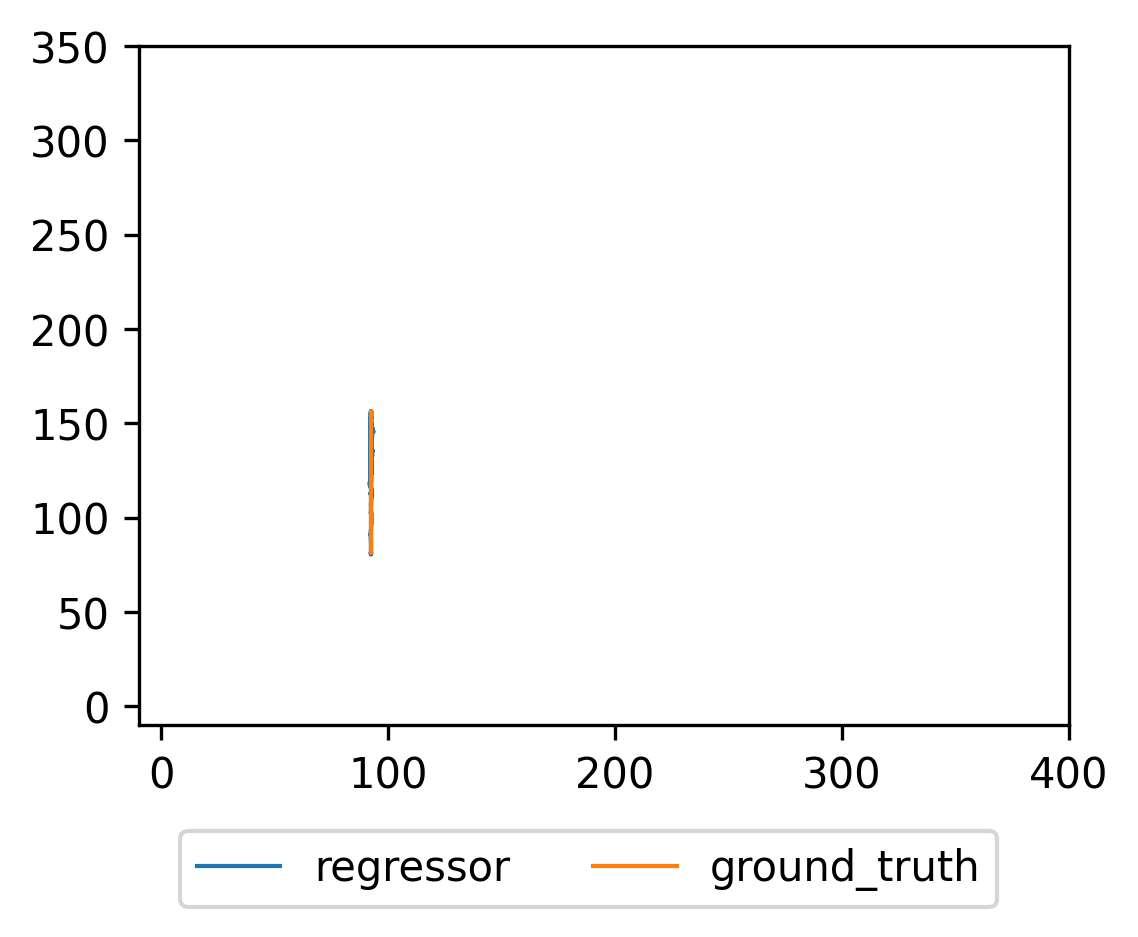

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_427.pt


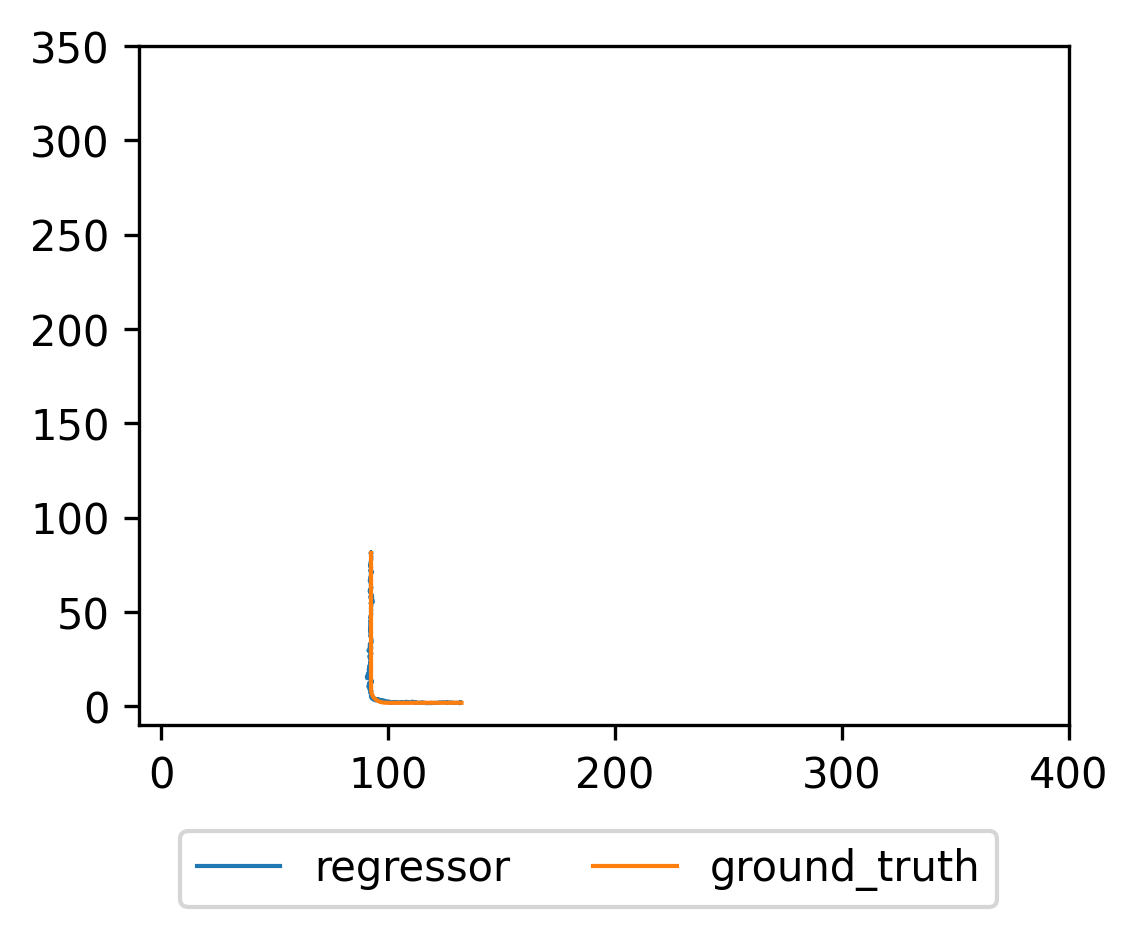

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_428.pt


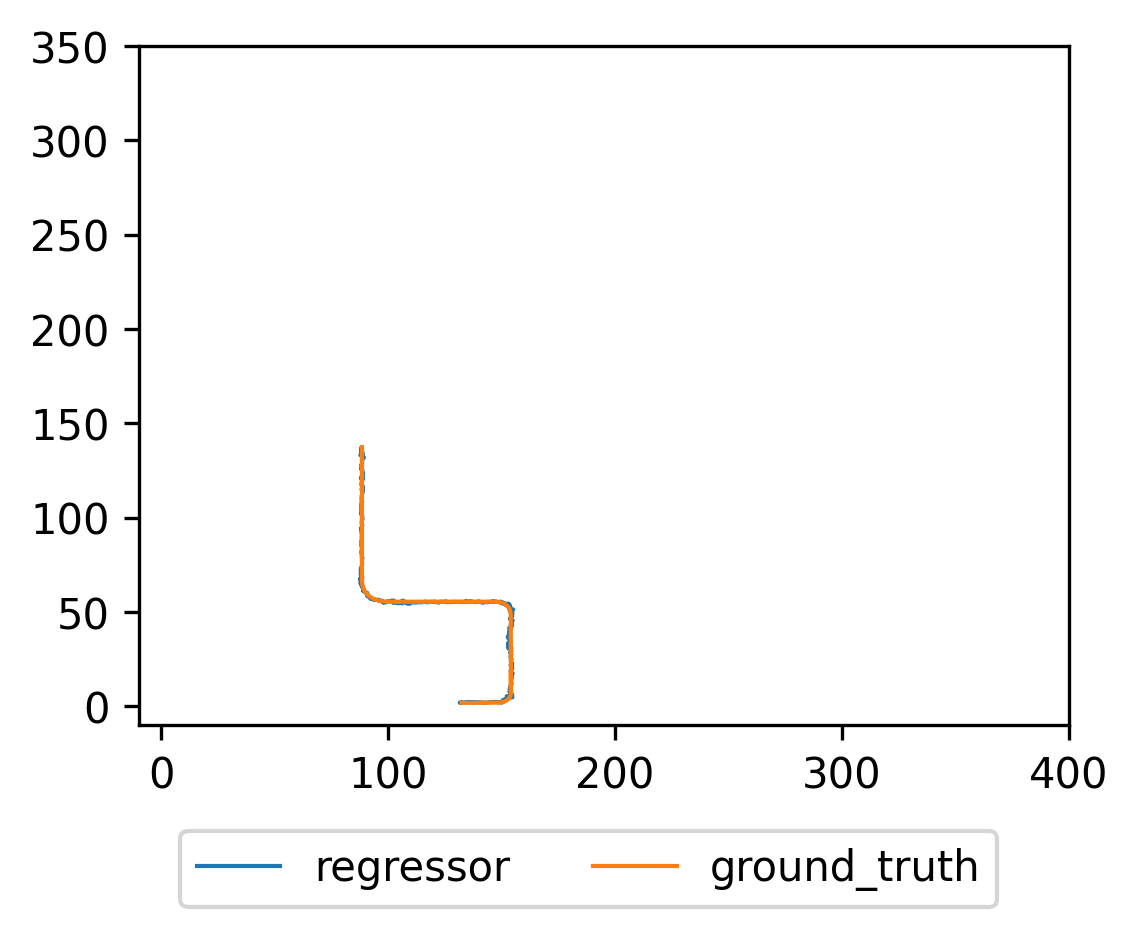

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_429.pt


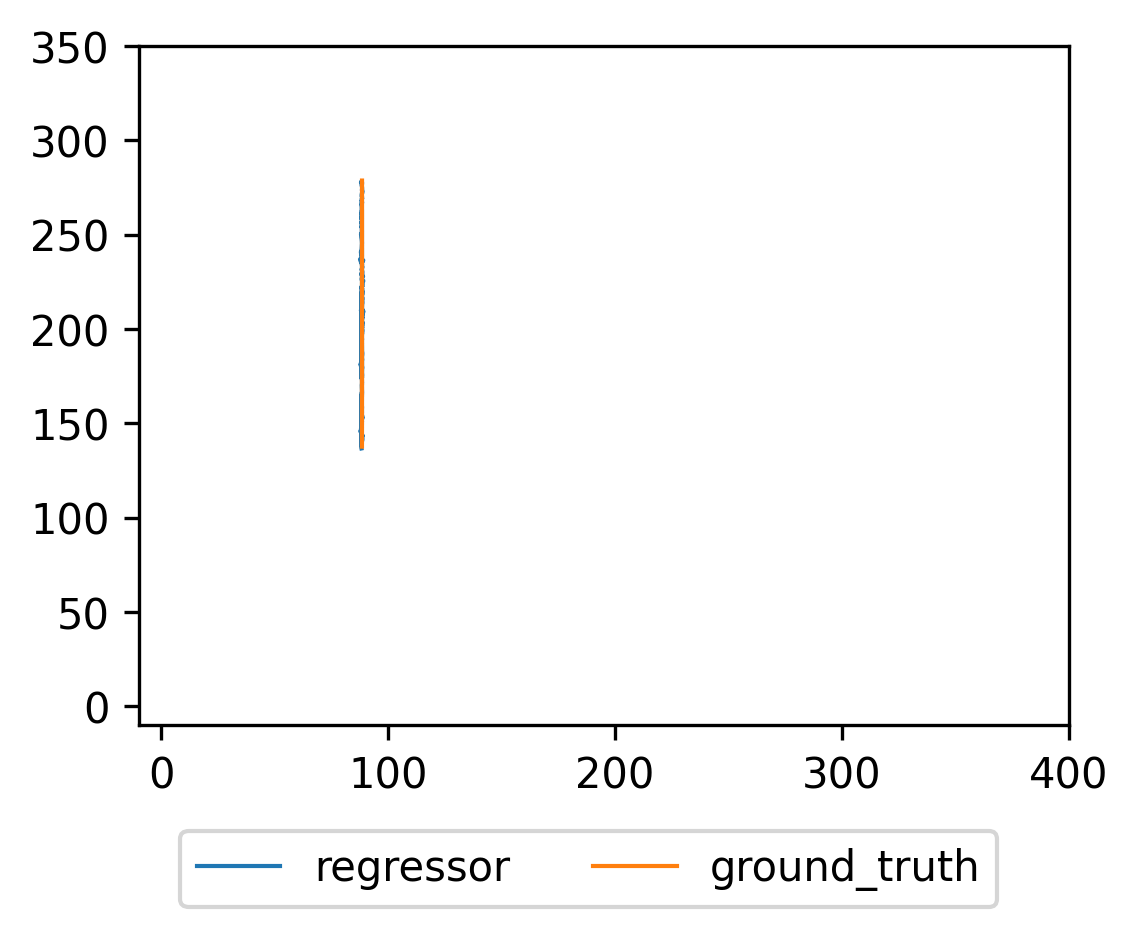

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_430.pt


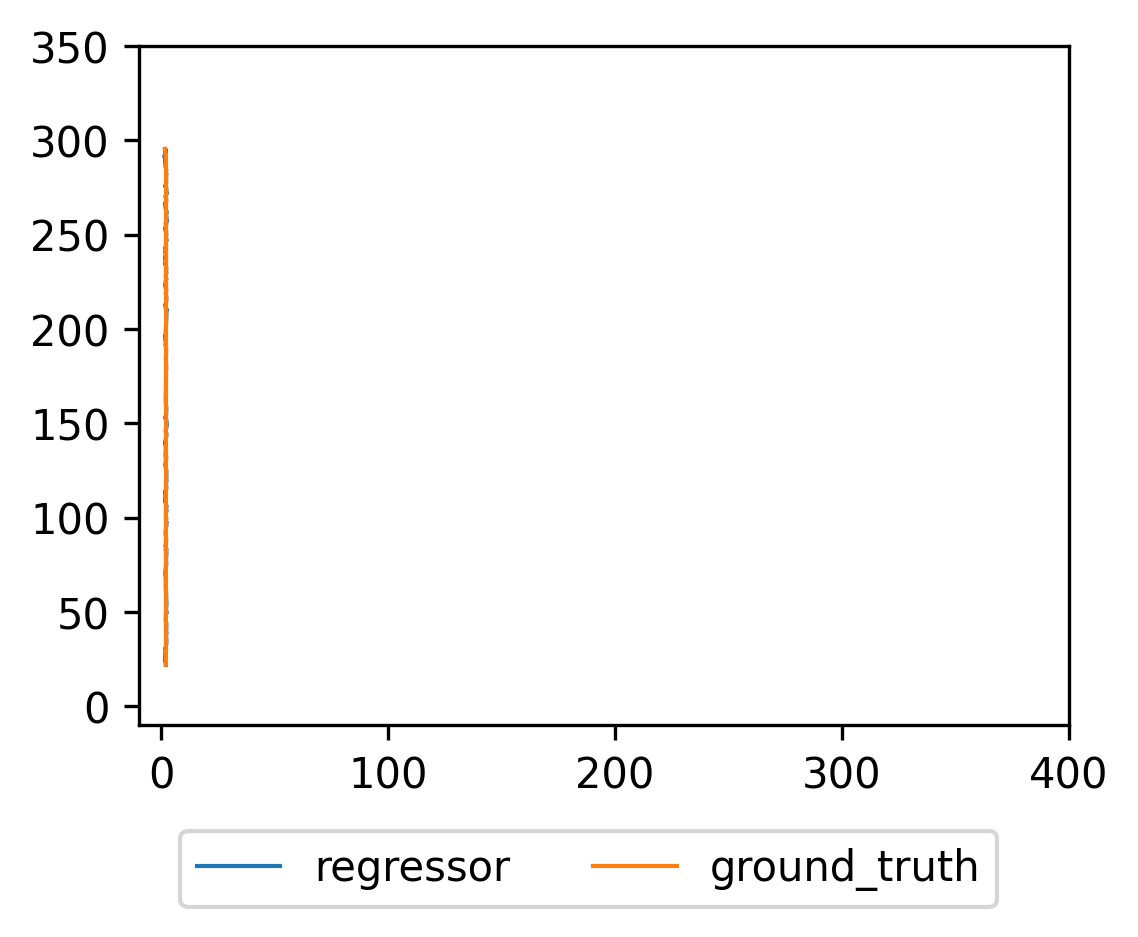

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_431.pt


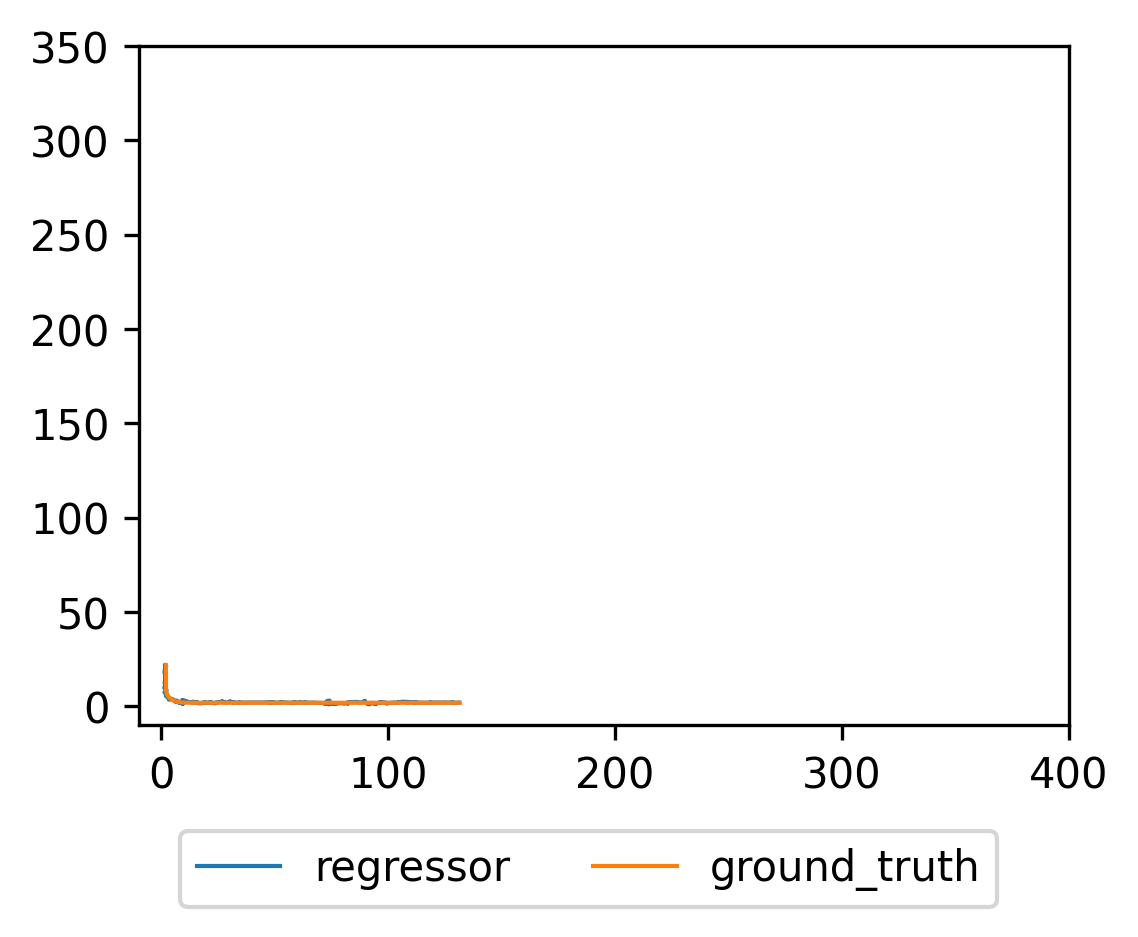

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_432.pt


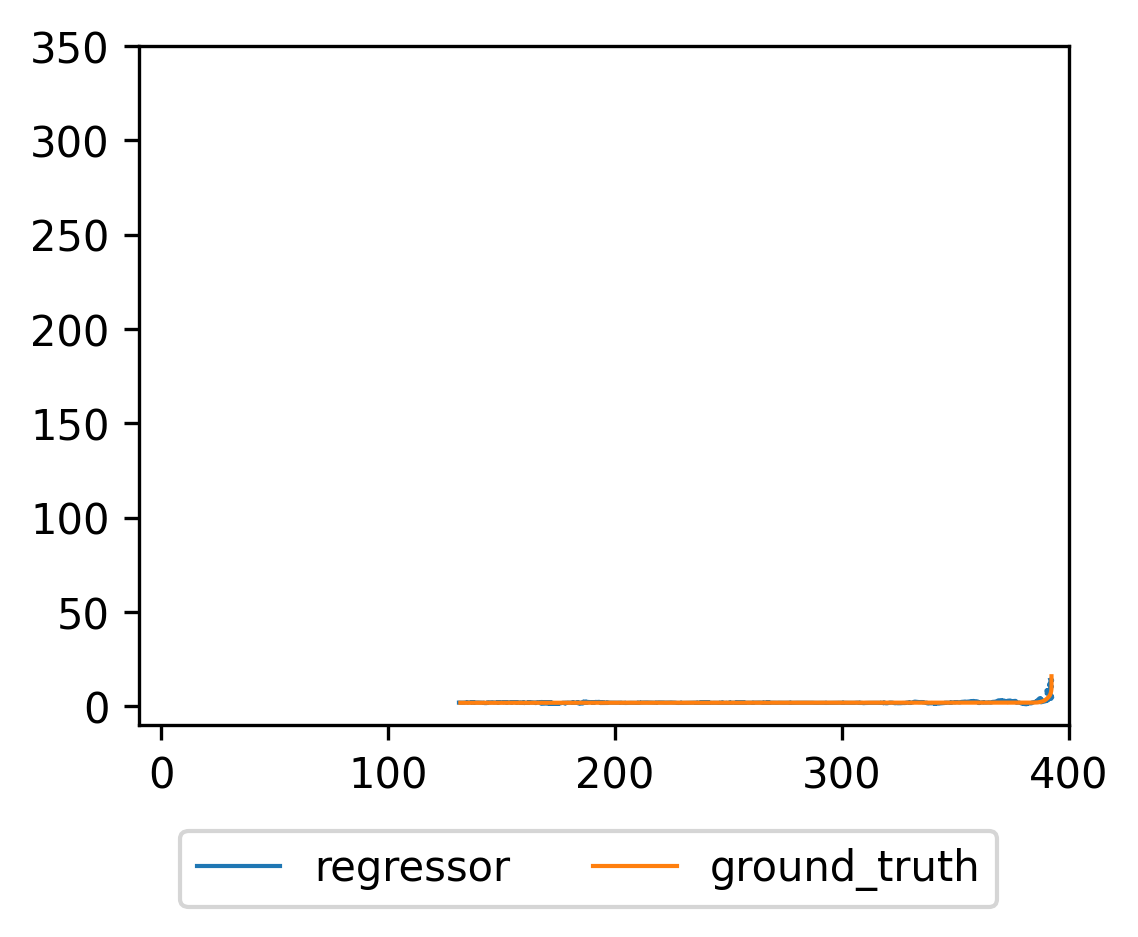

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_433.pt


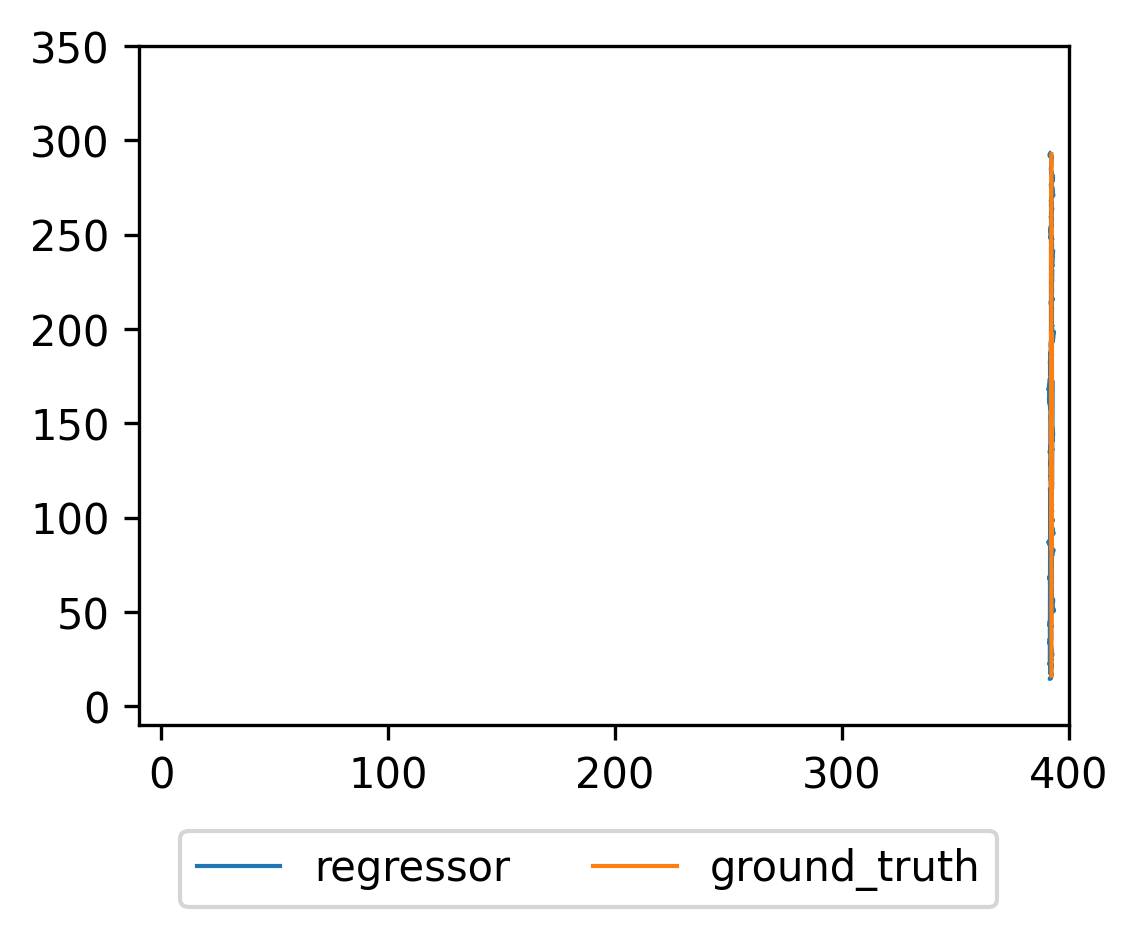

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_434.pt


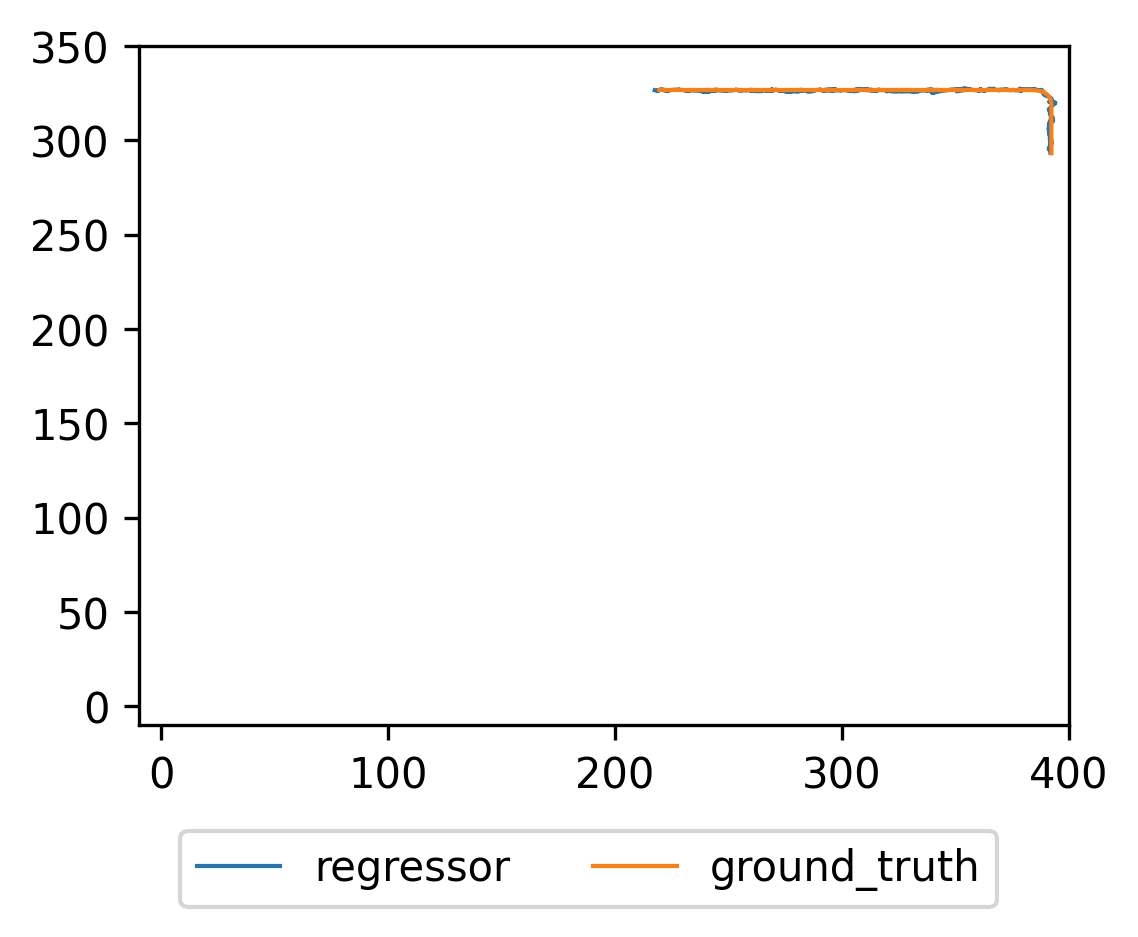

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_435.pt


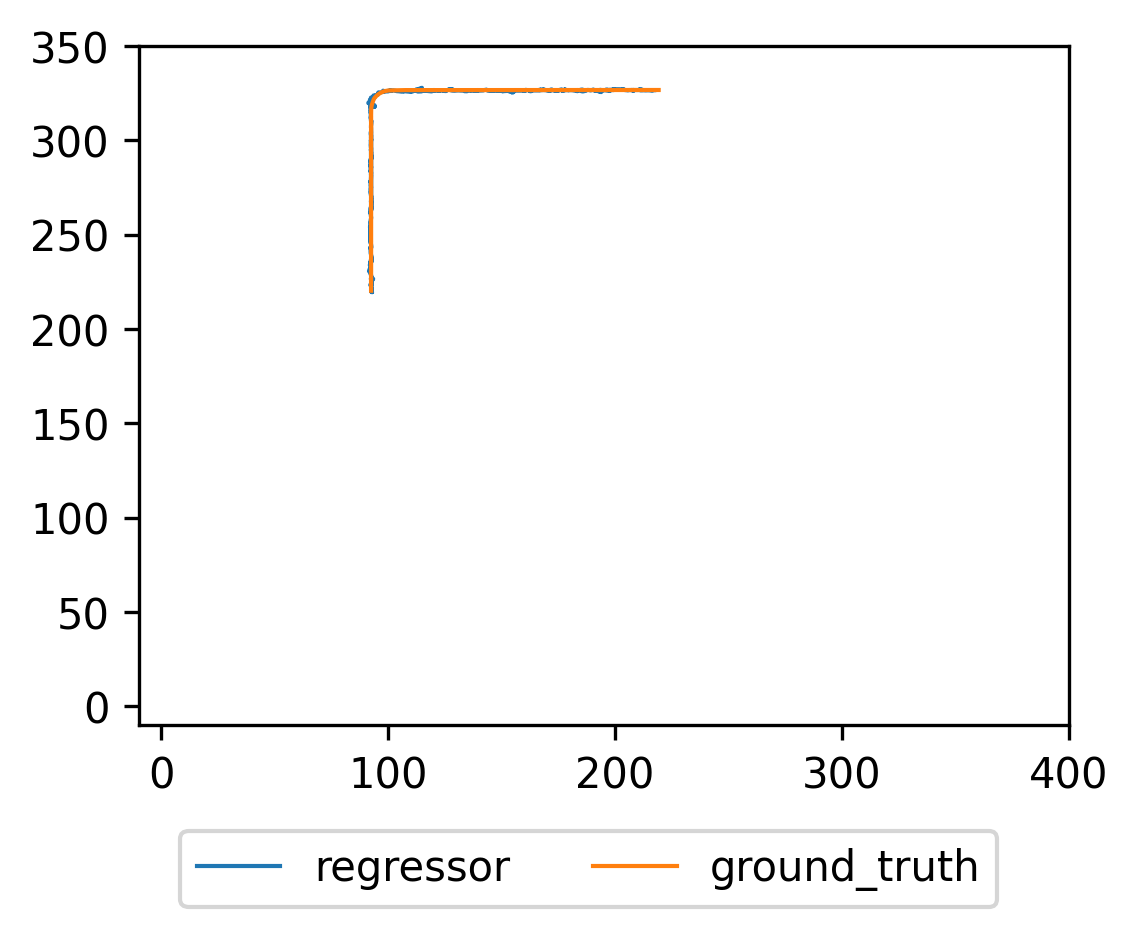

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_436.pt


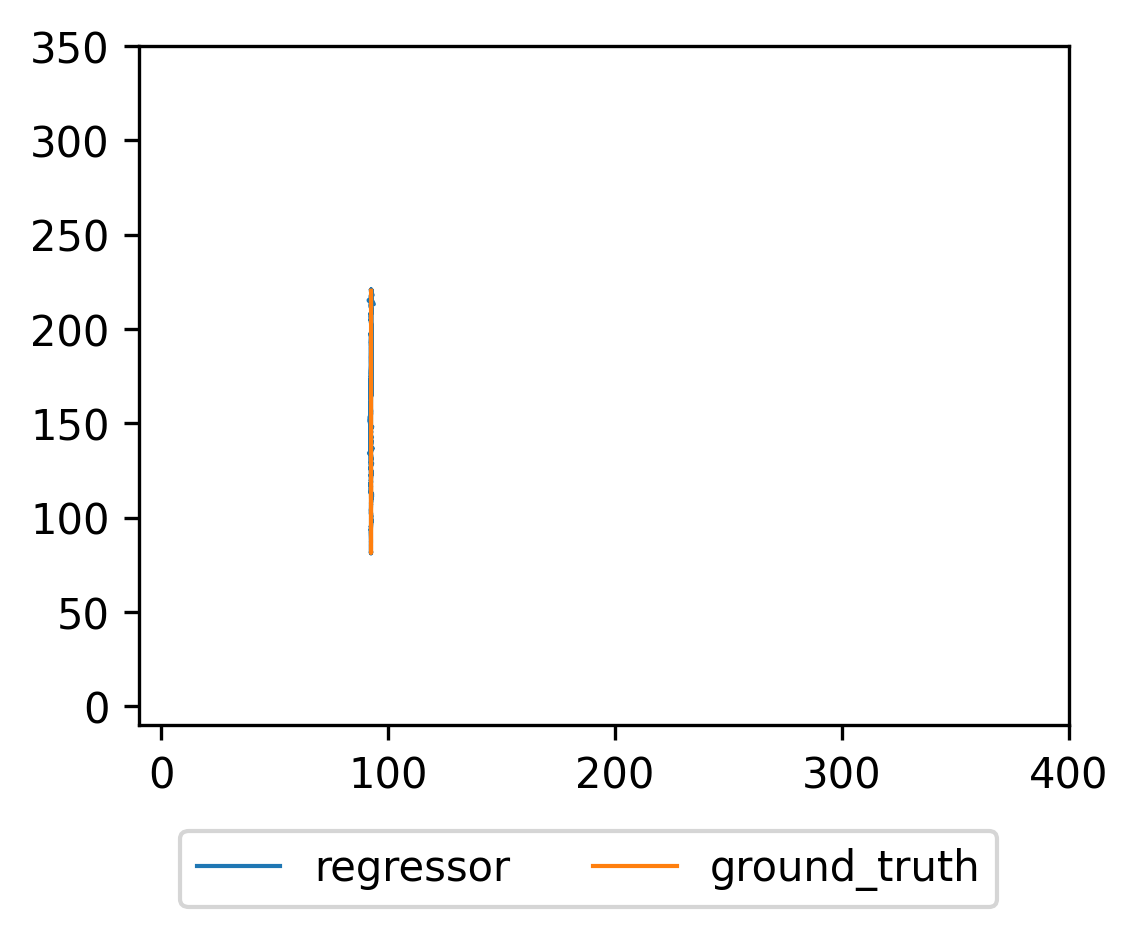

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_440.pt


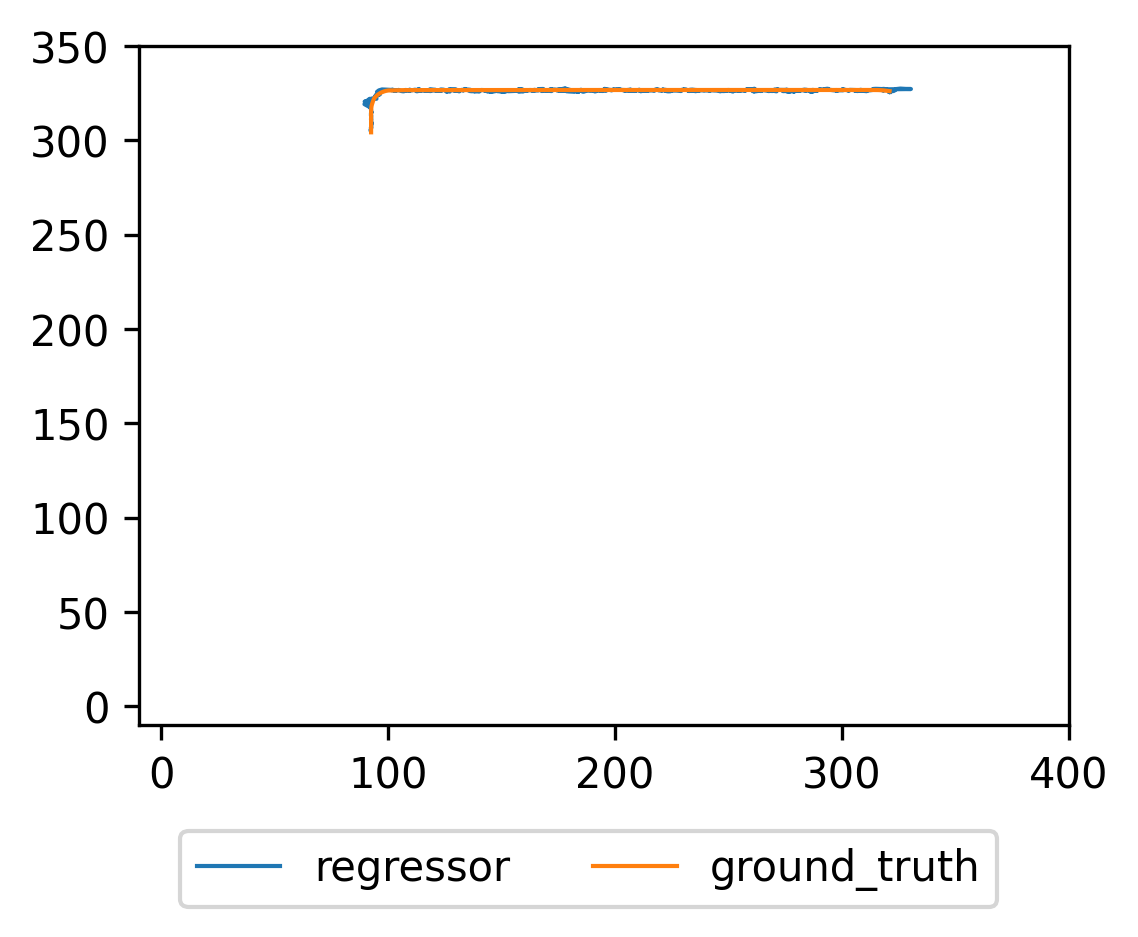

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_441.pt


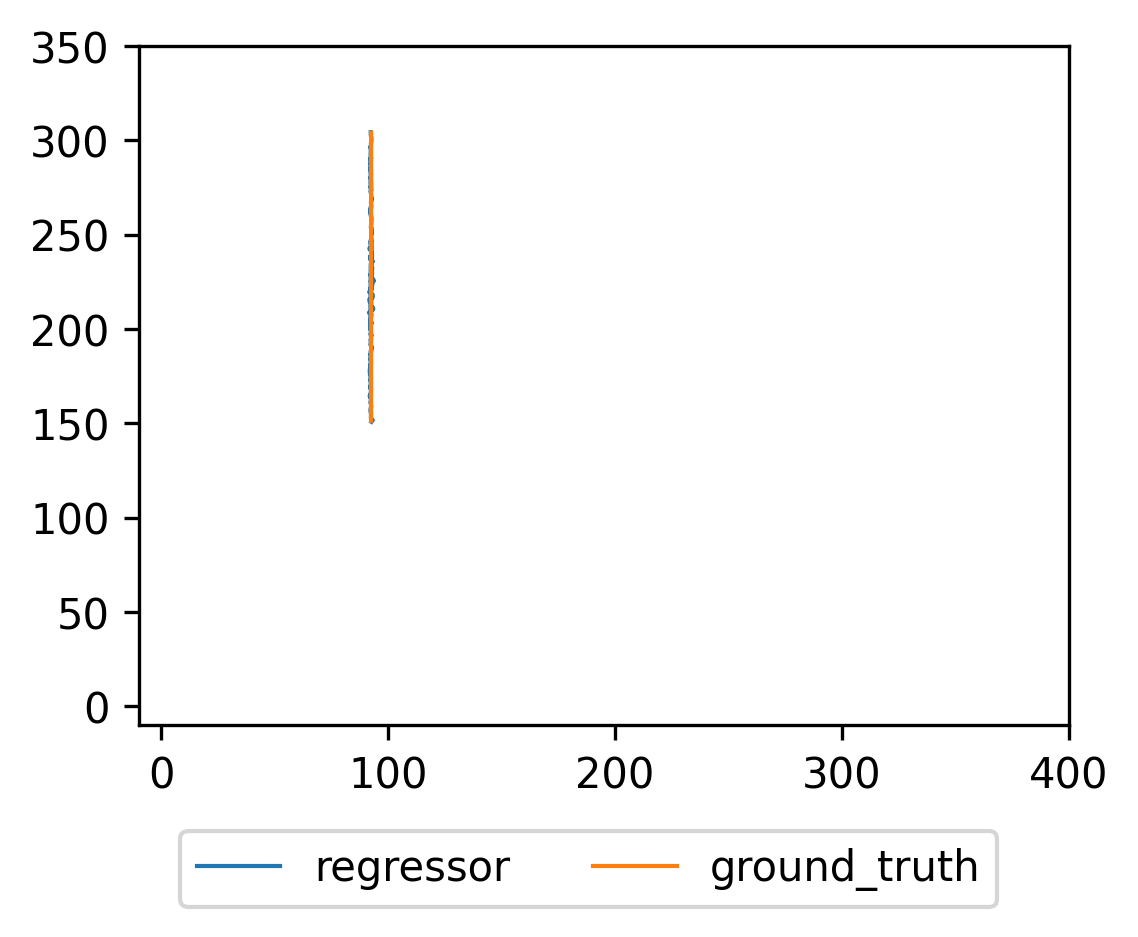

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_442.pt


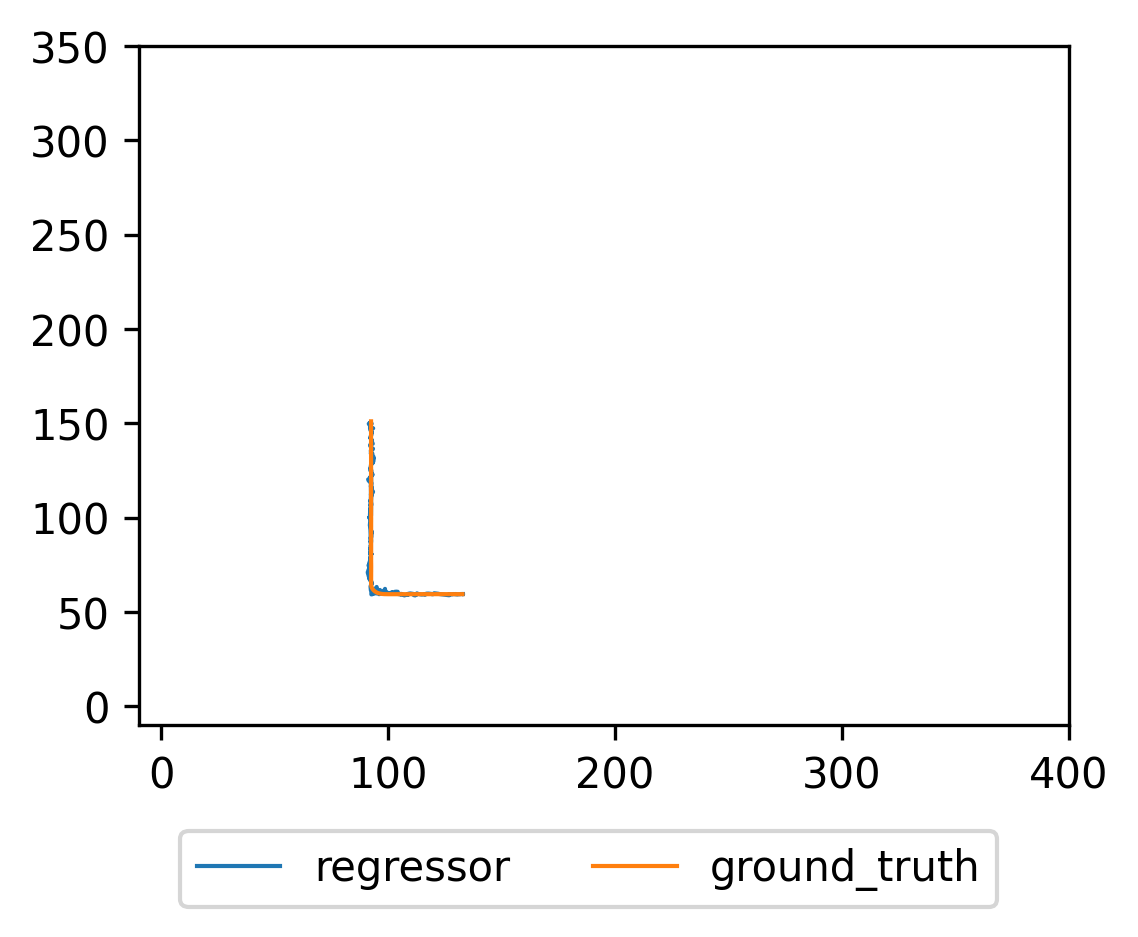

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_443.pt


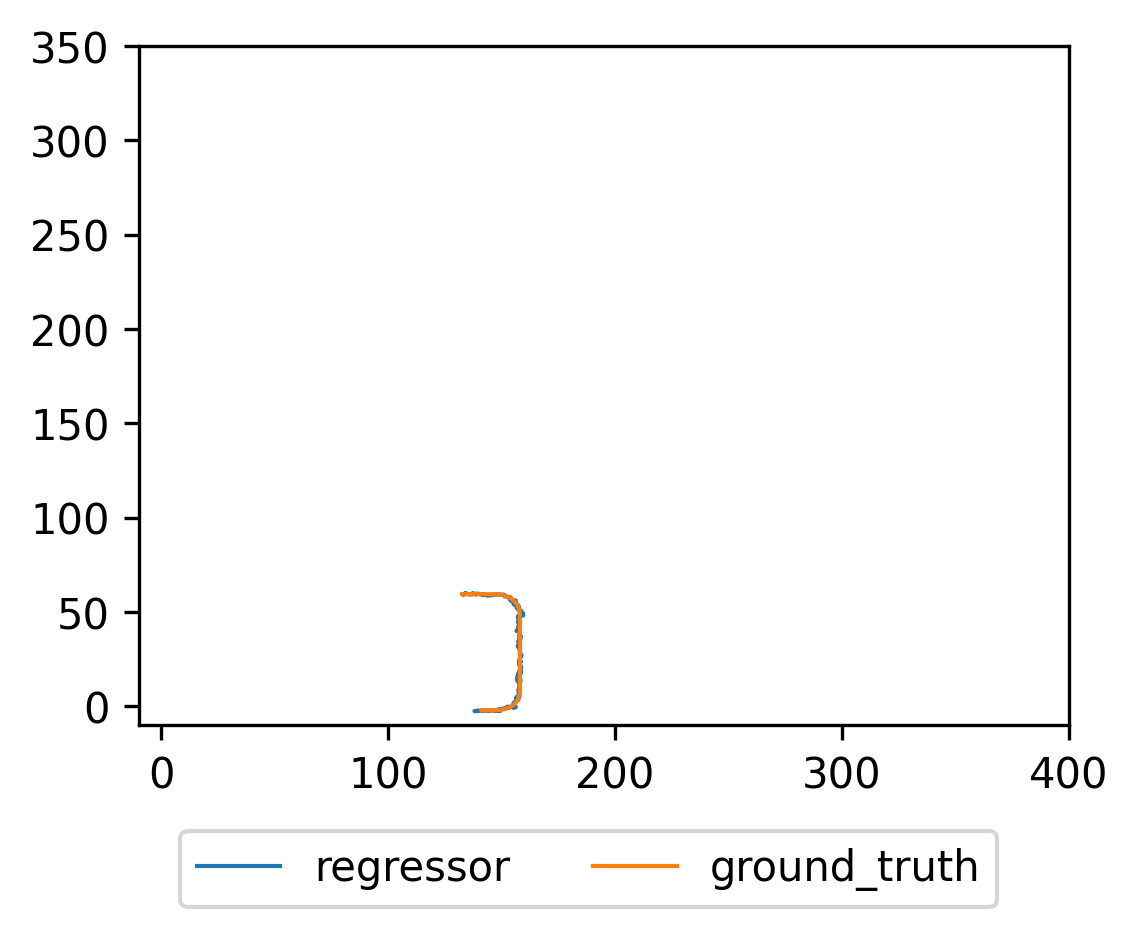

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_444.pt


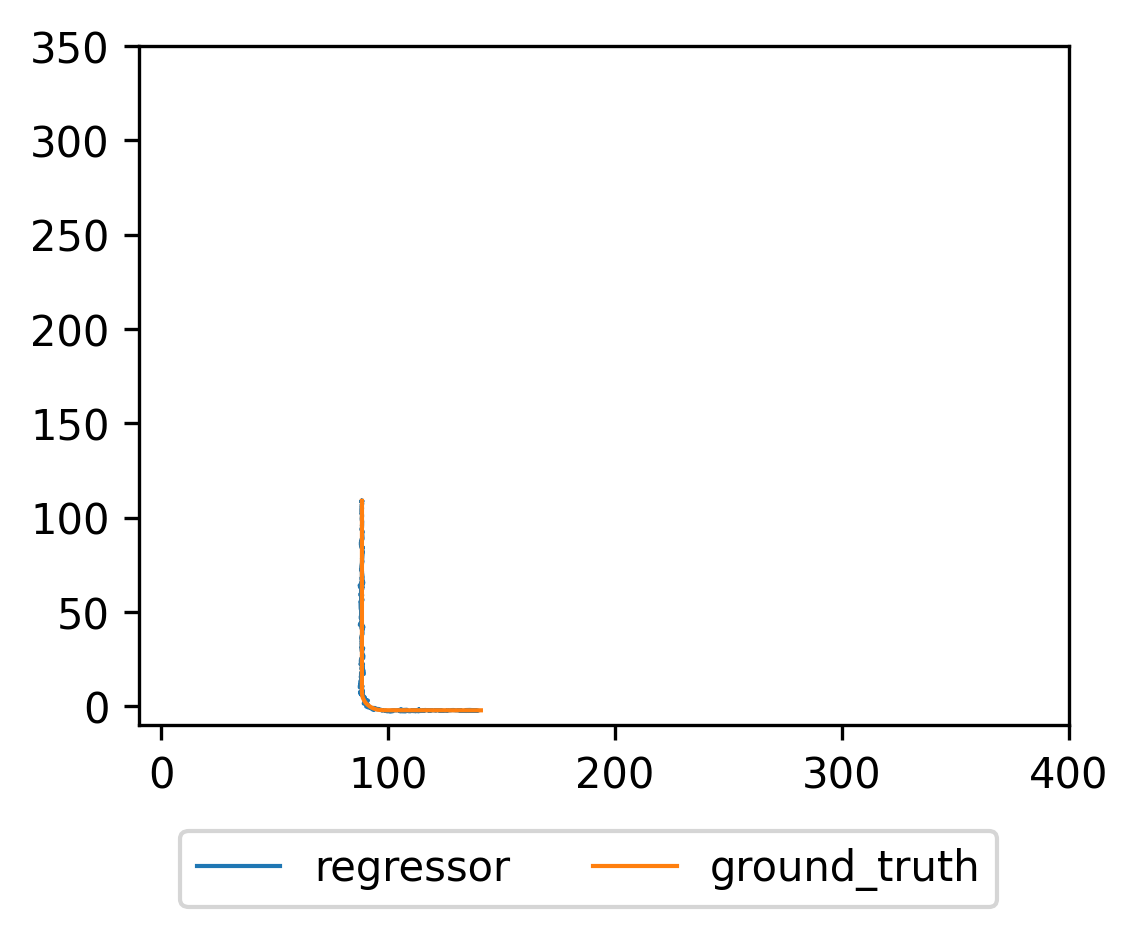

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_445.pt


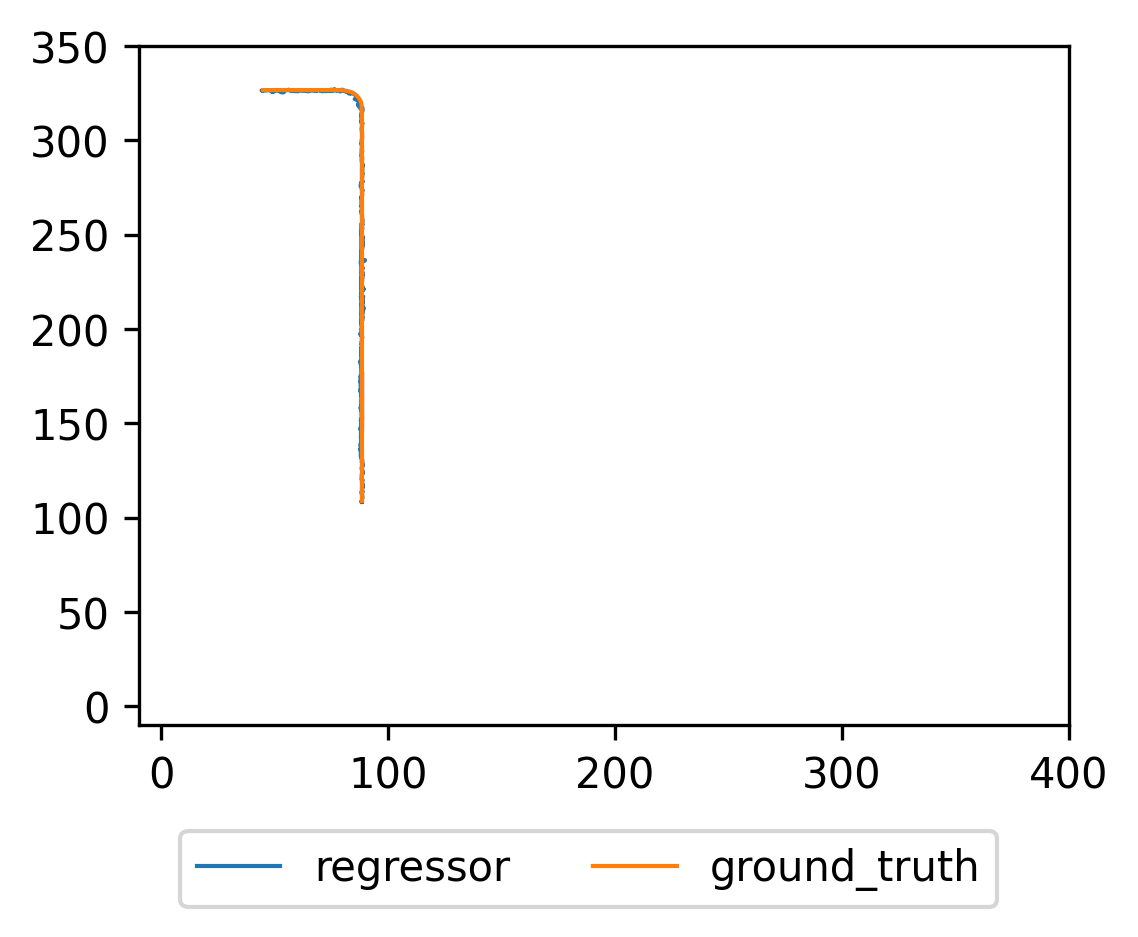

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_446.pt


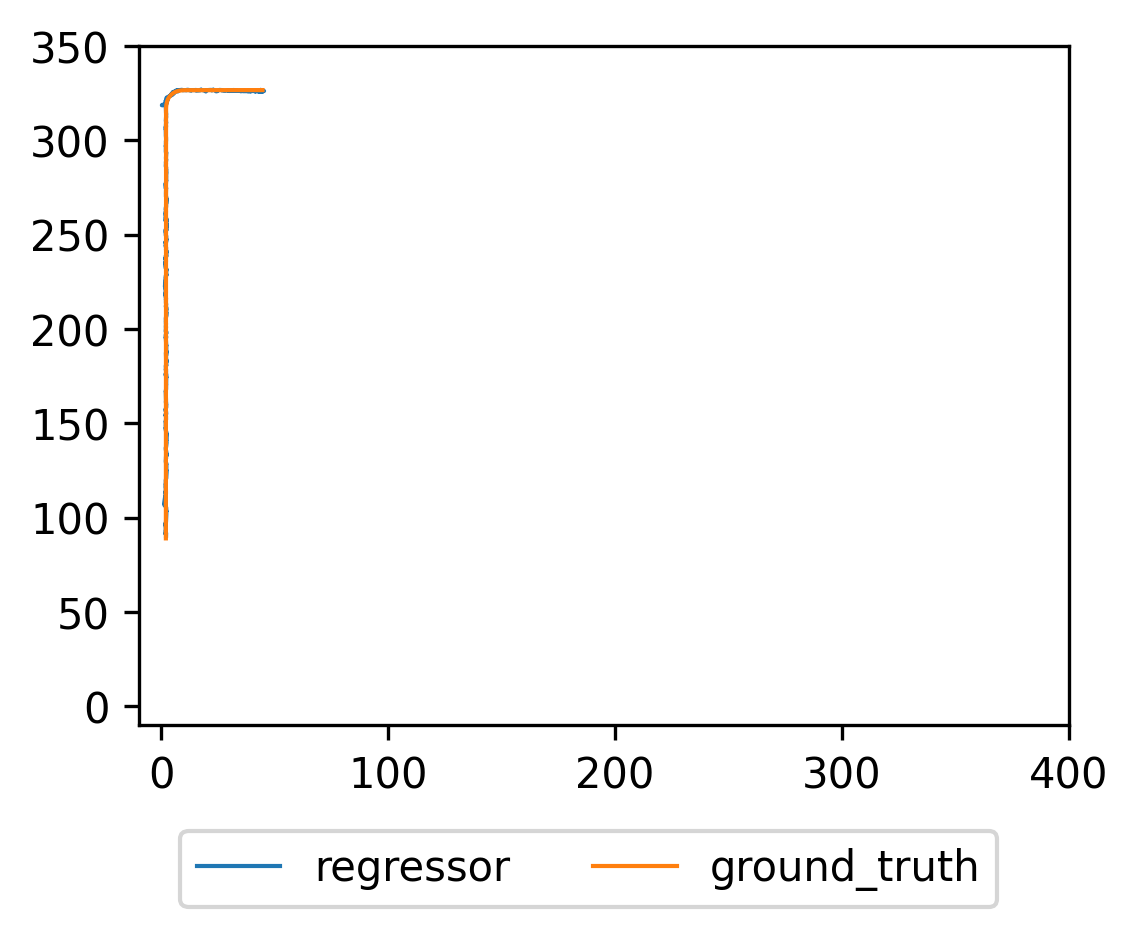

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_447.pt


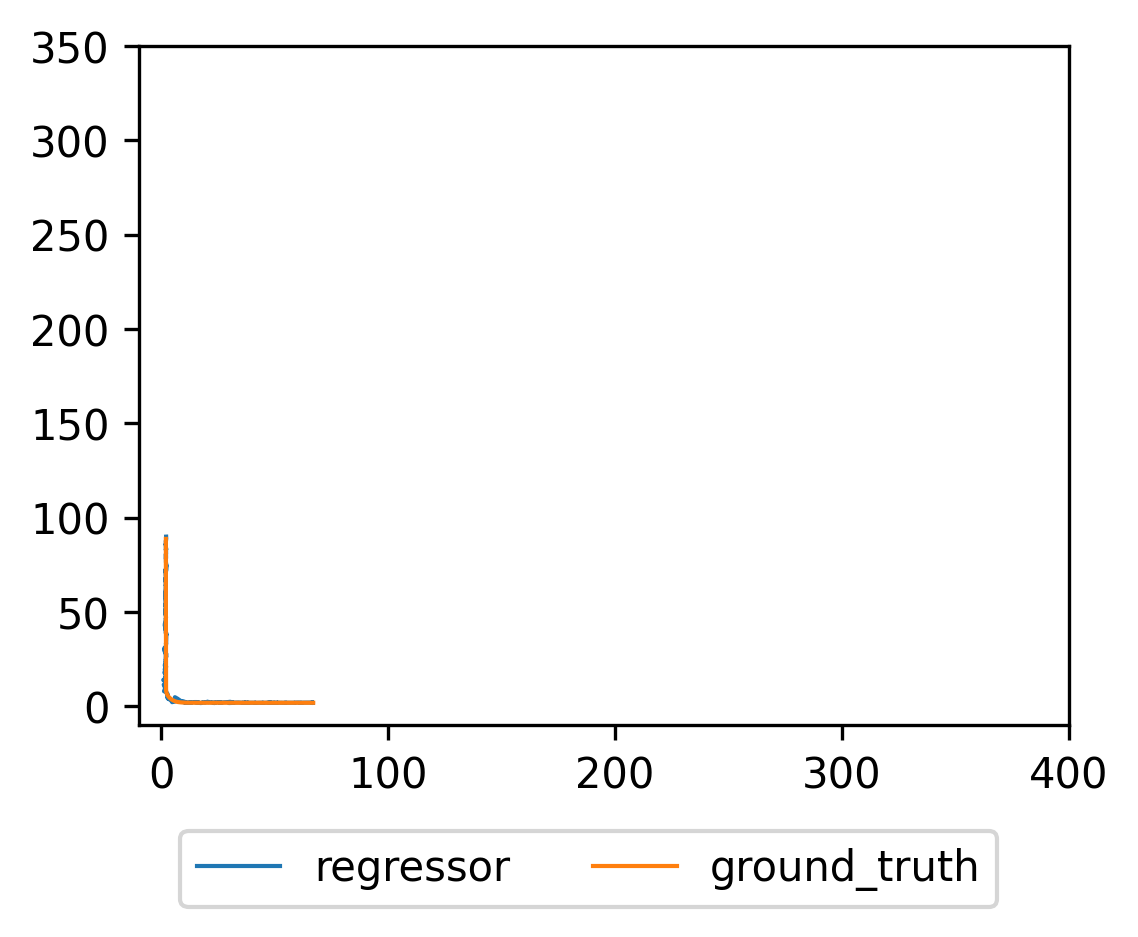

In [65]:
for i in range(20):
    path = df.iloc[i,0]
    out, gt, cells_pred, cells_gt = predict_trajectory(path)
    k = path.split('/')[-1]
    plot_trajectory(out, gt, k)

# old results for comparison

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_425.pt


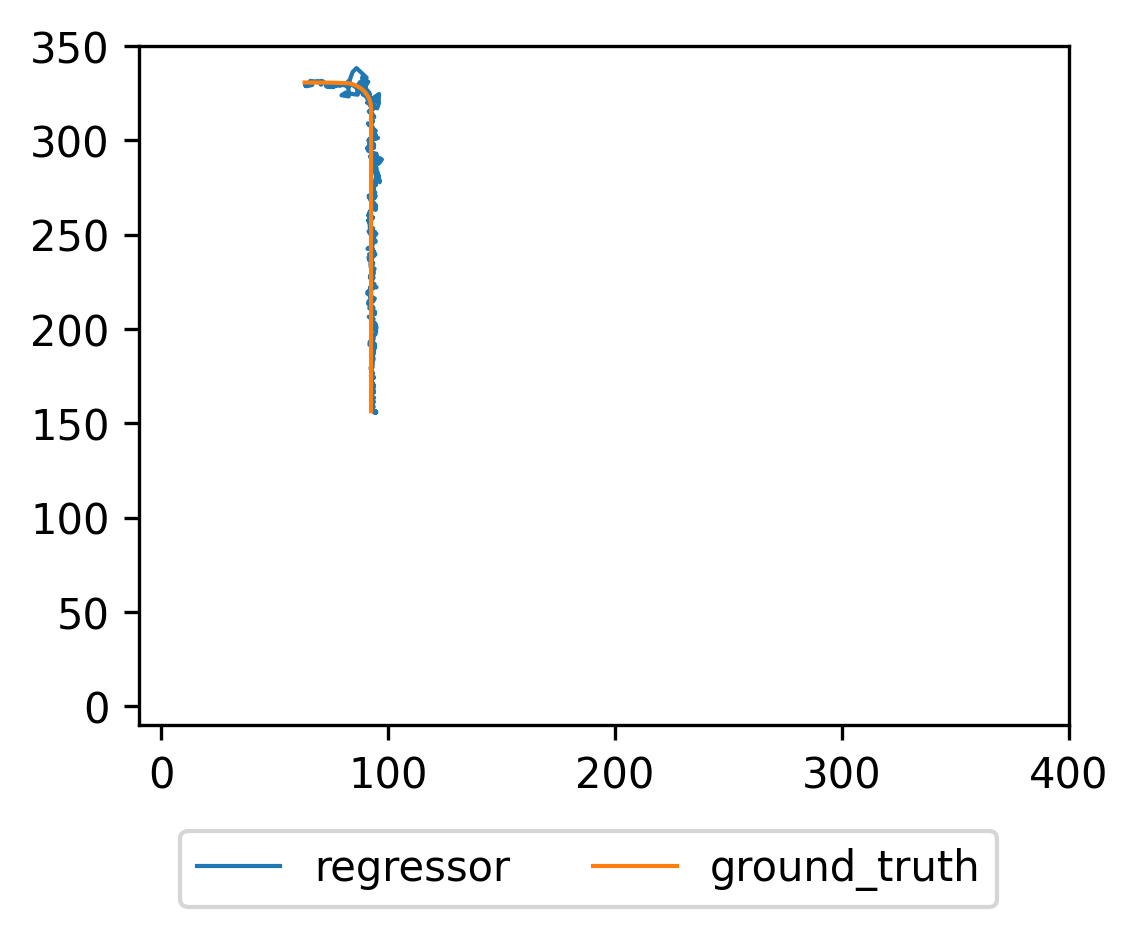

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_426.pt


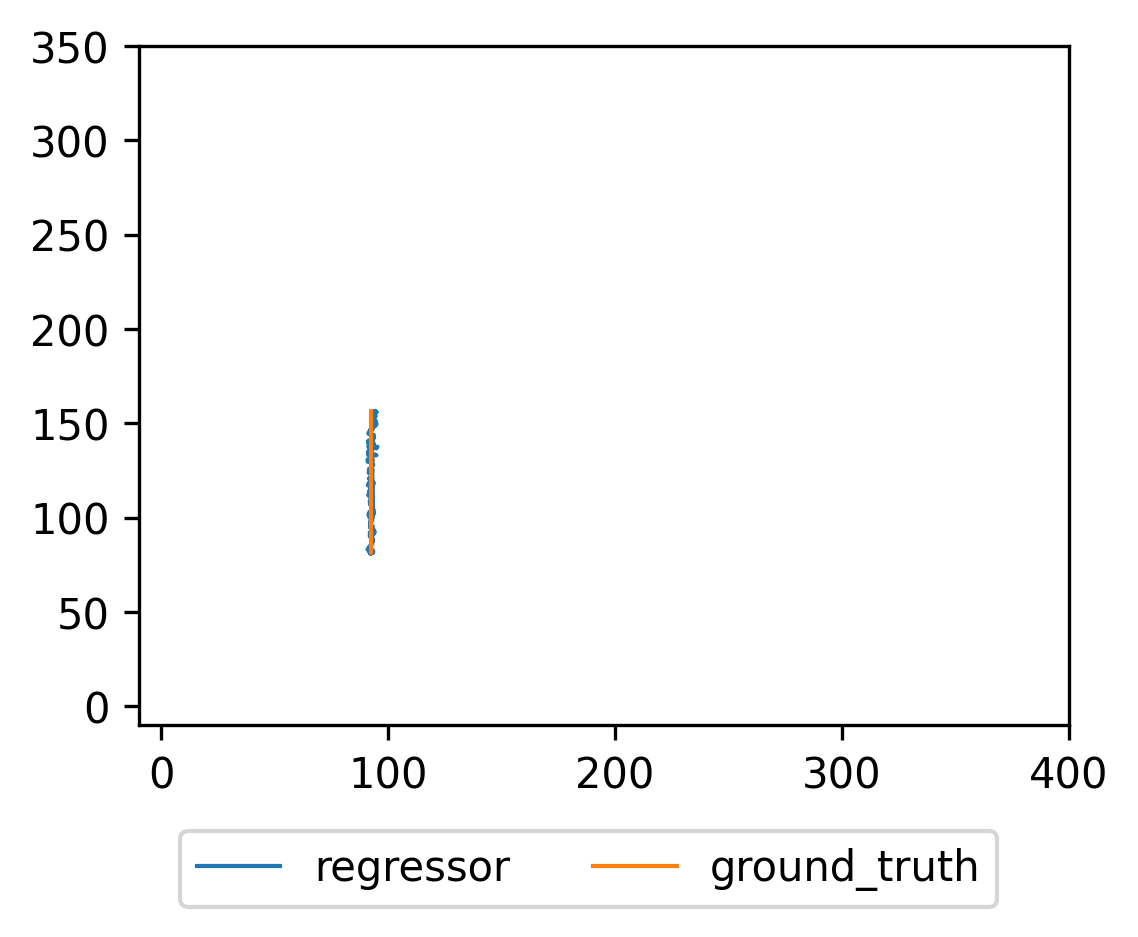

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_427.pt


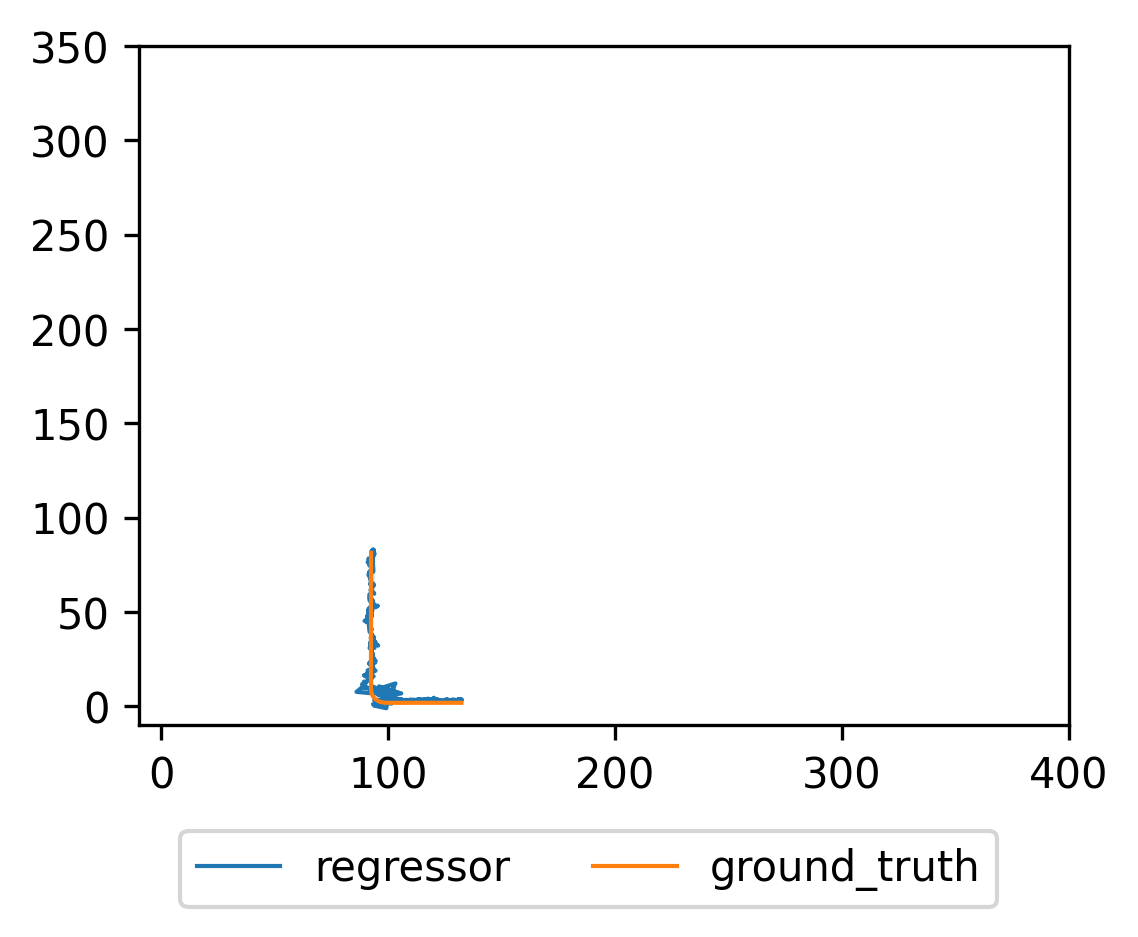

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_428.pt


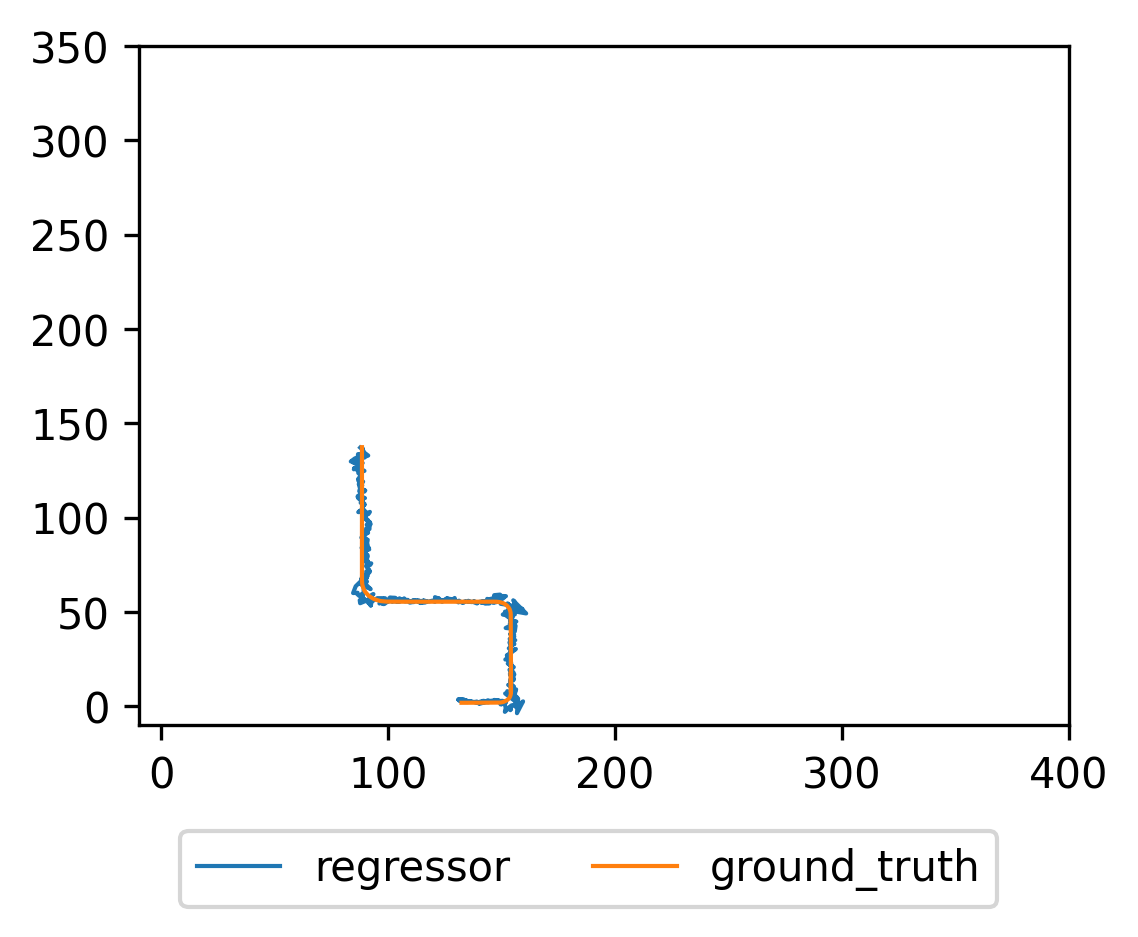

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_429.pt


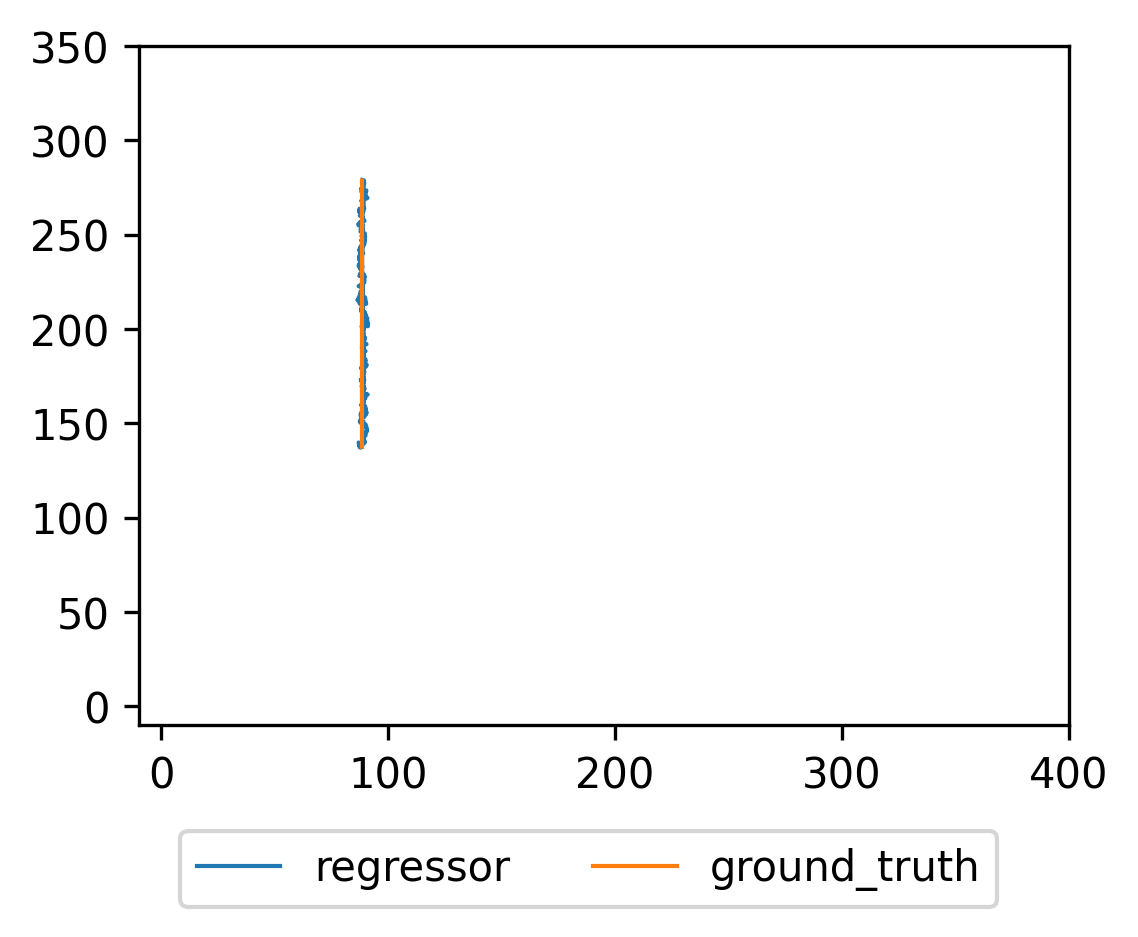

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_430.pt


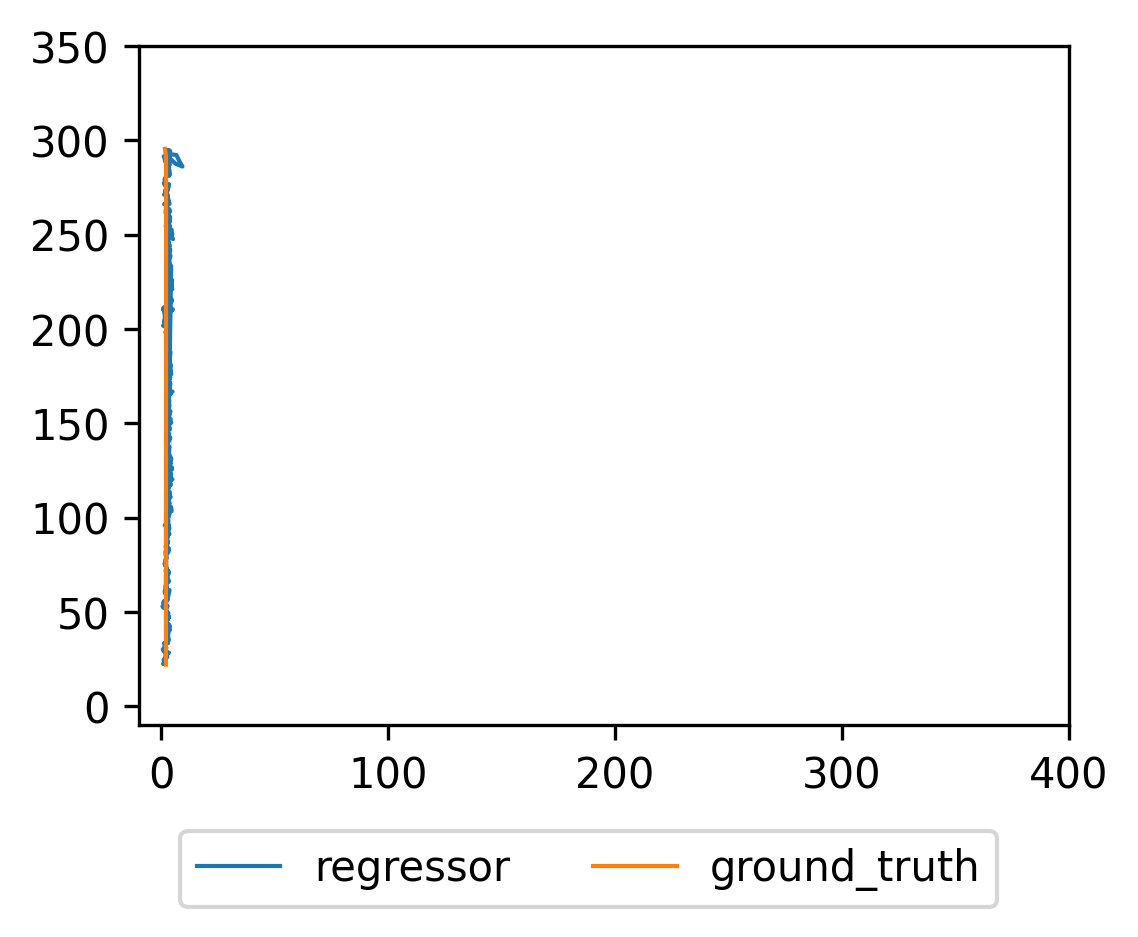

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_431.pt


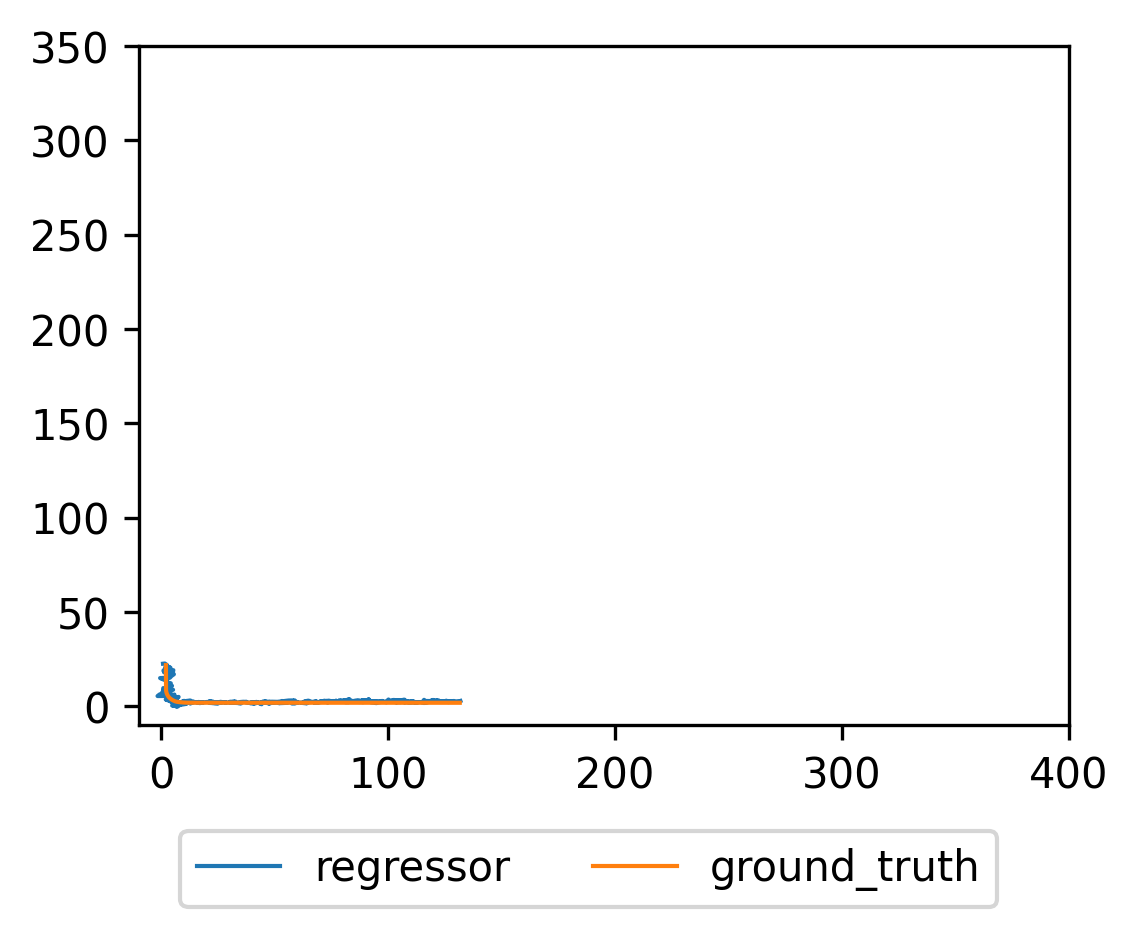

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_432.pt


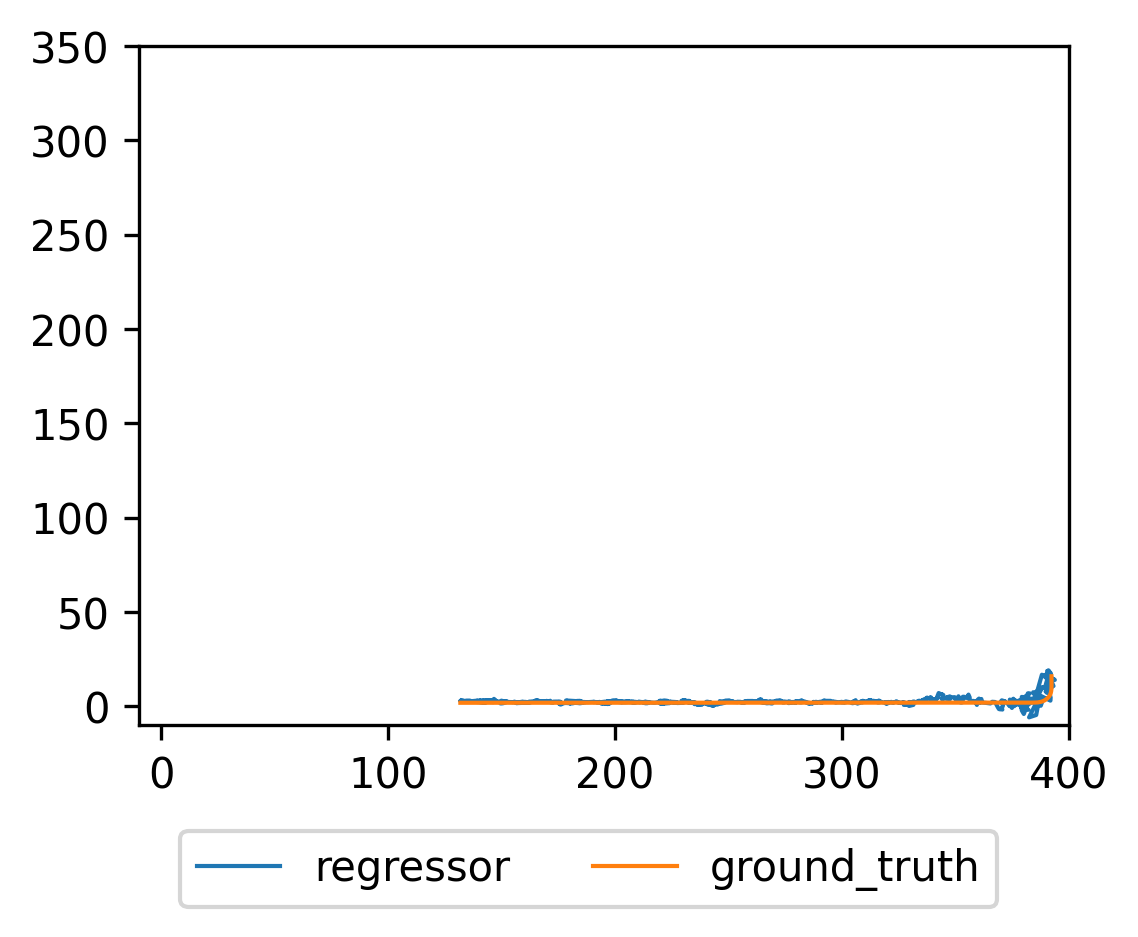

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_433.pt


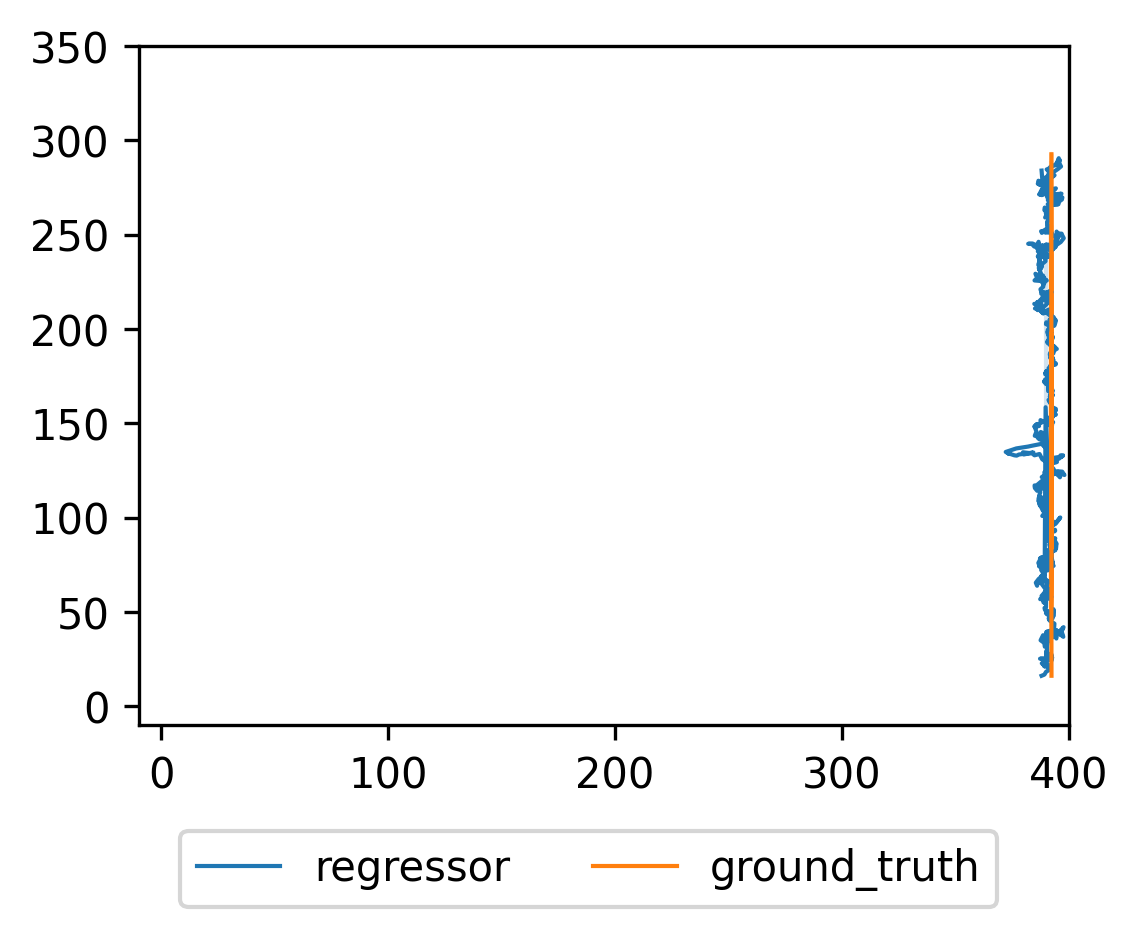

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_434.pt


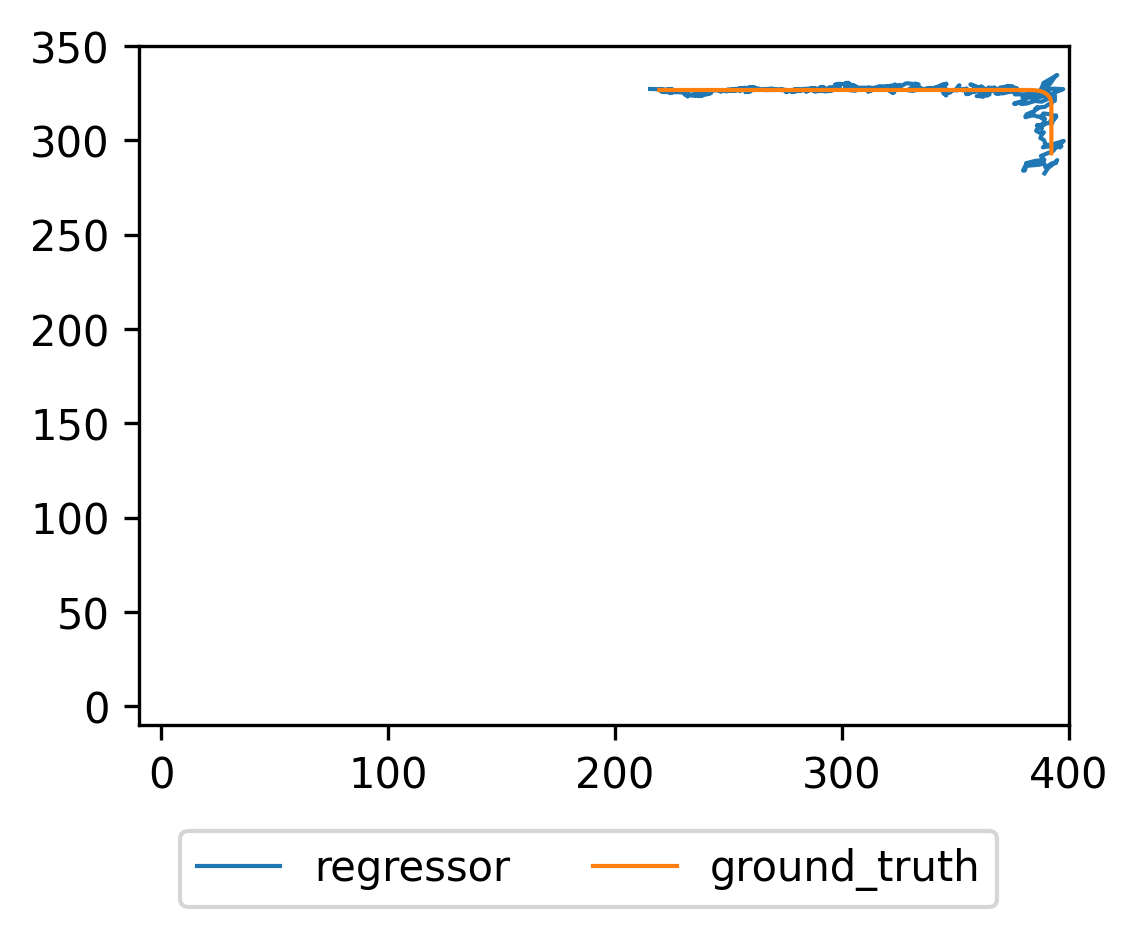

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_435.pt


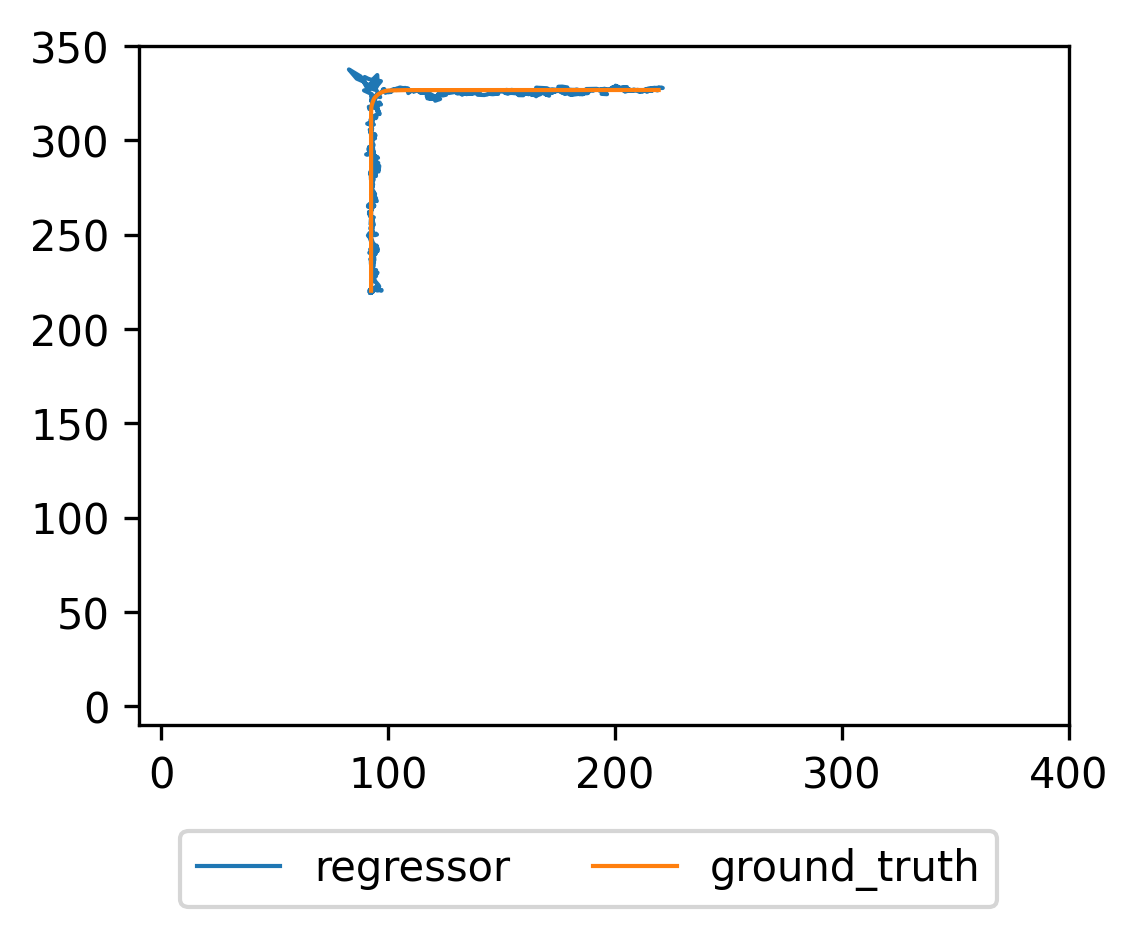

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_436.pt


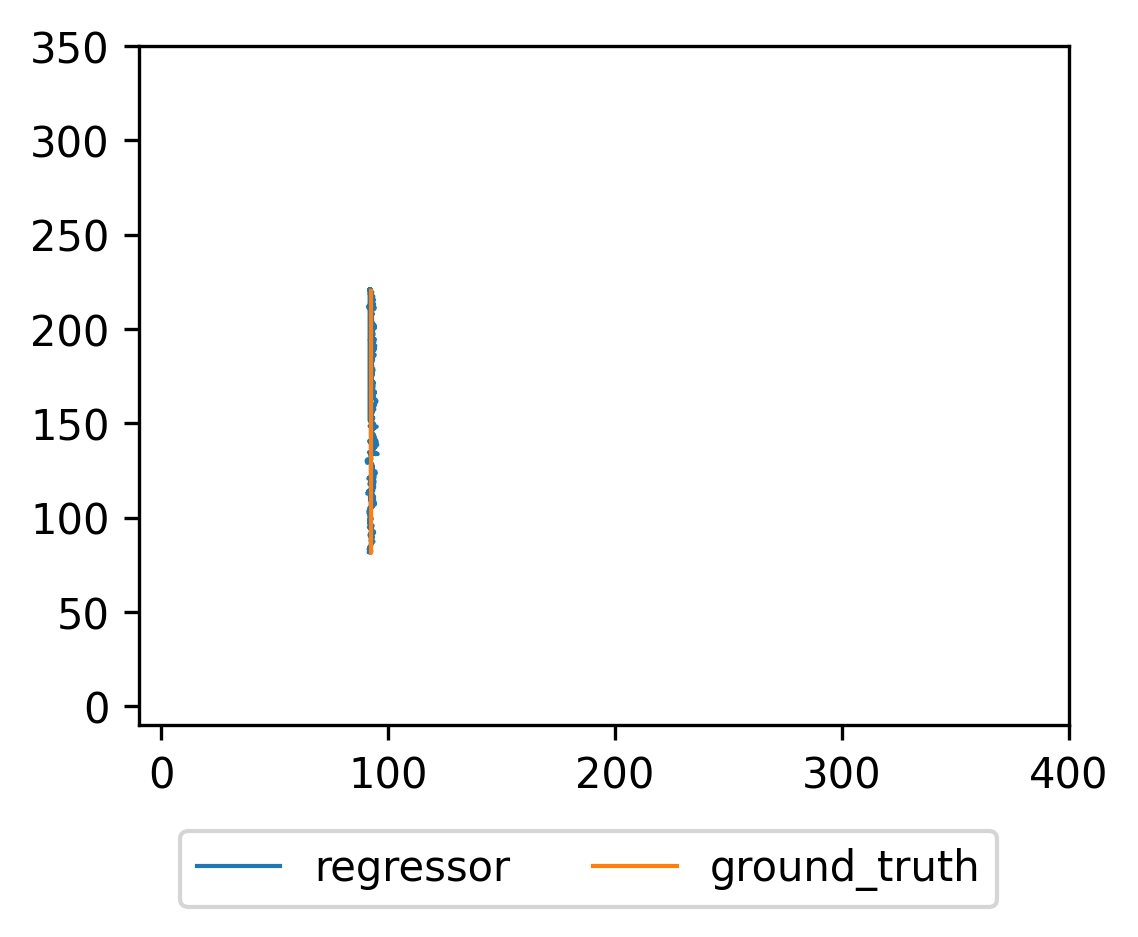

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_440.pt


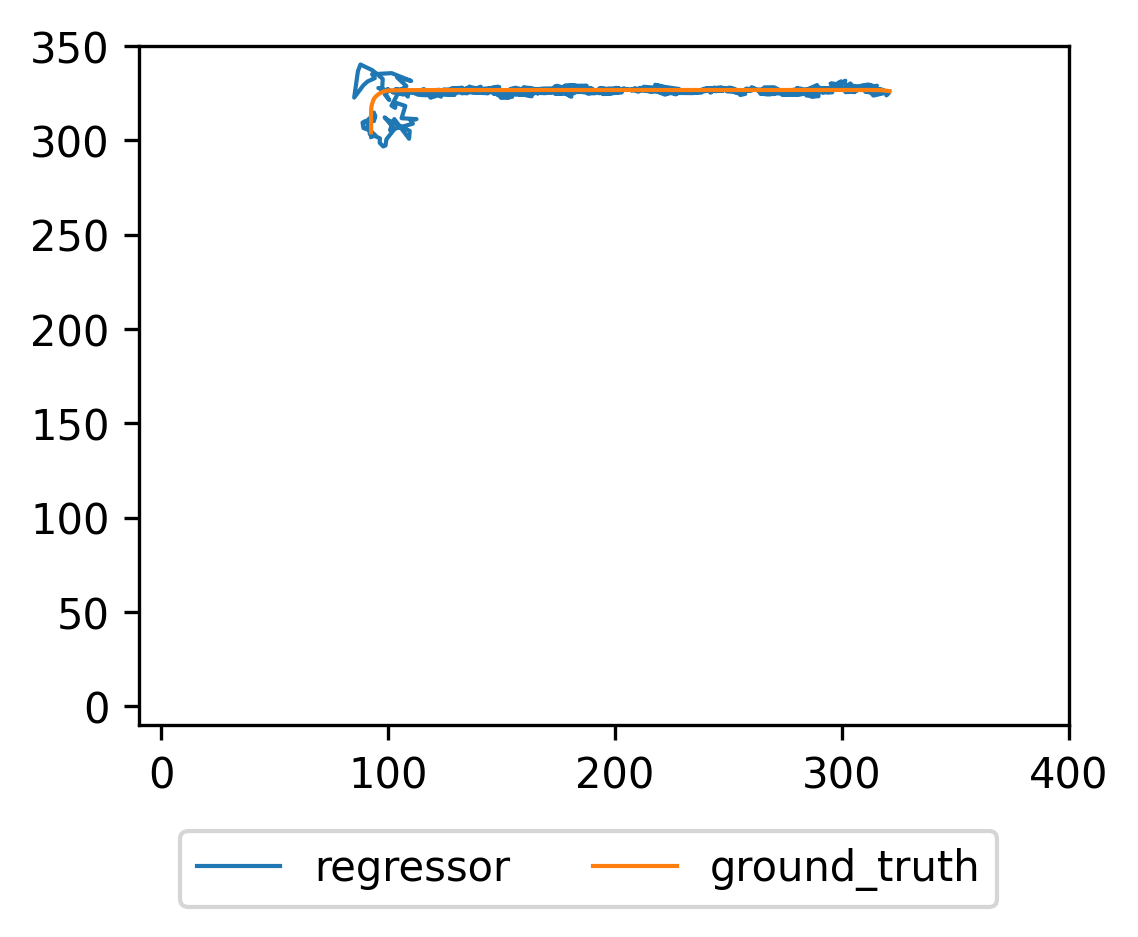

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_441.pt


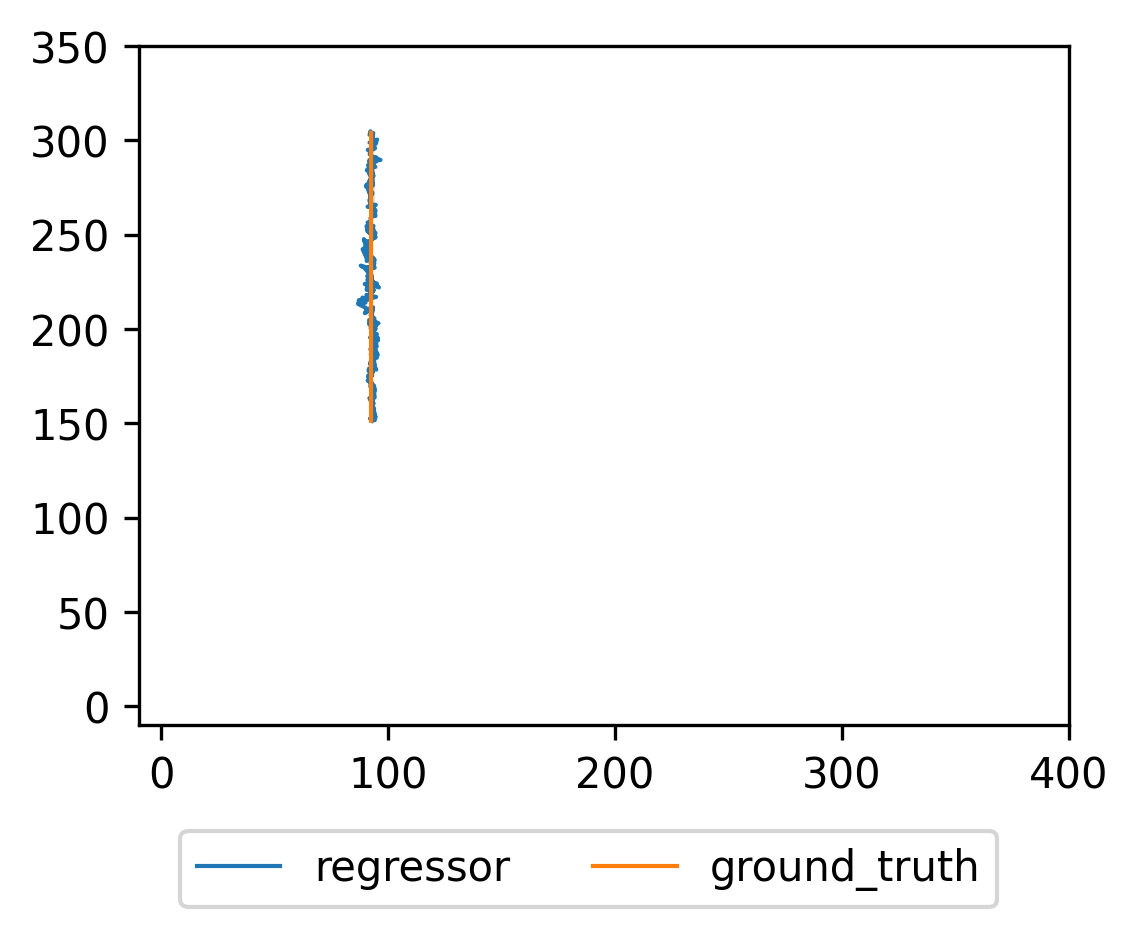

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_442.pt


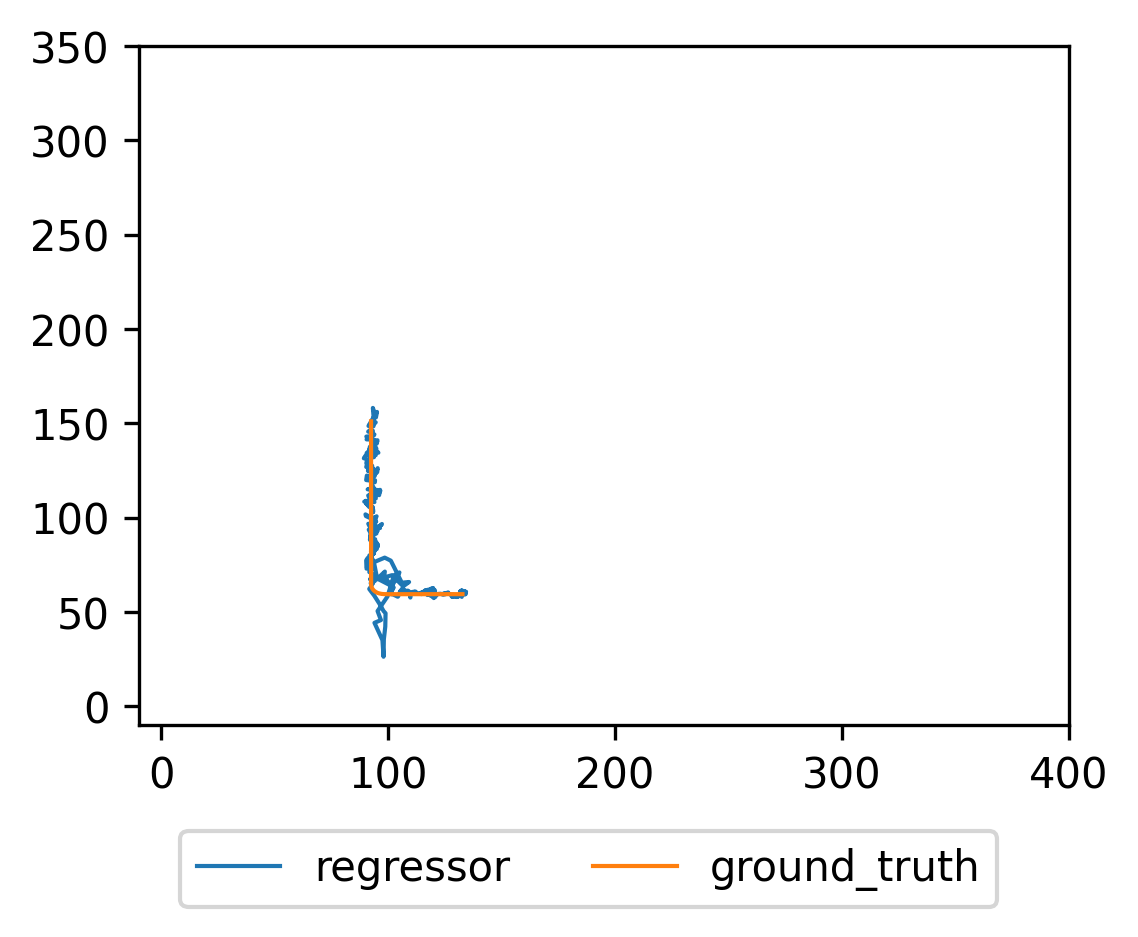

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_443.pt


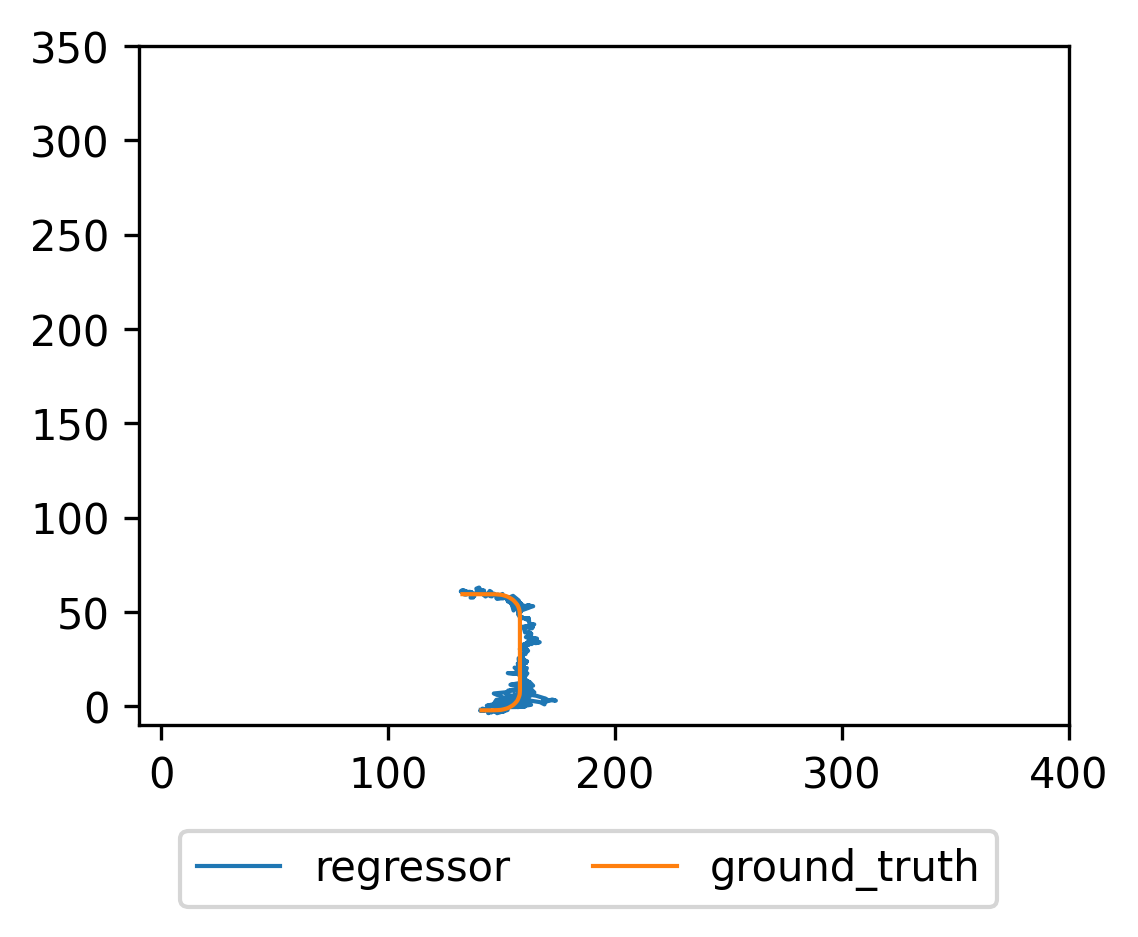

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_444.pt


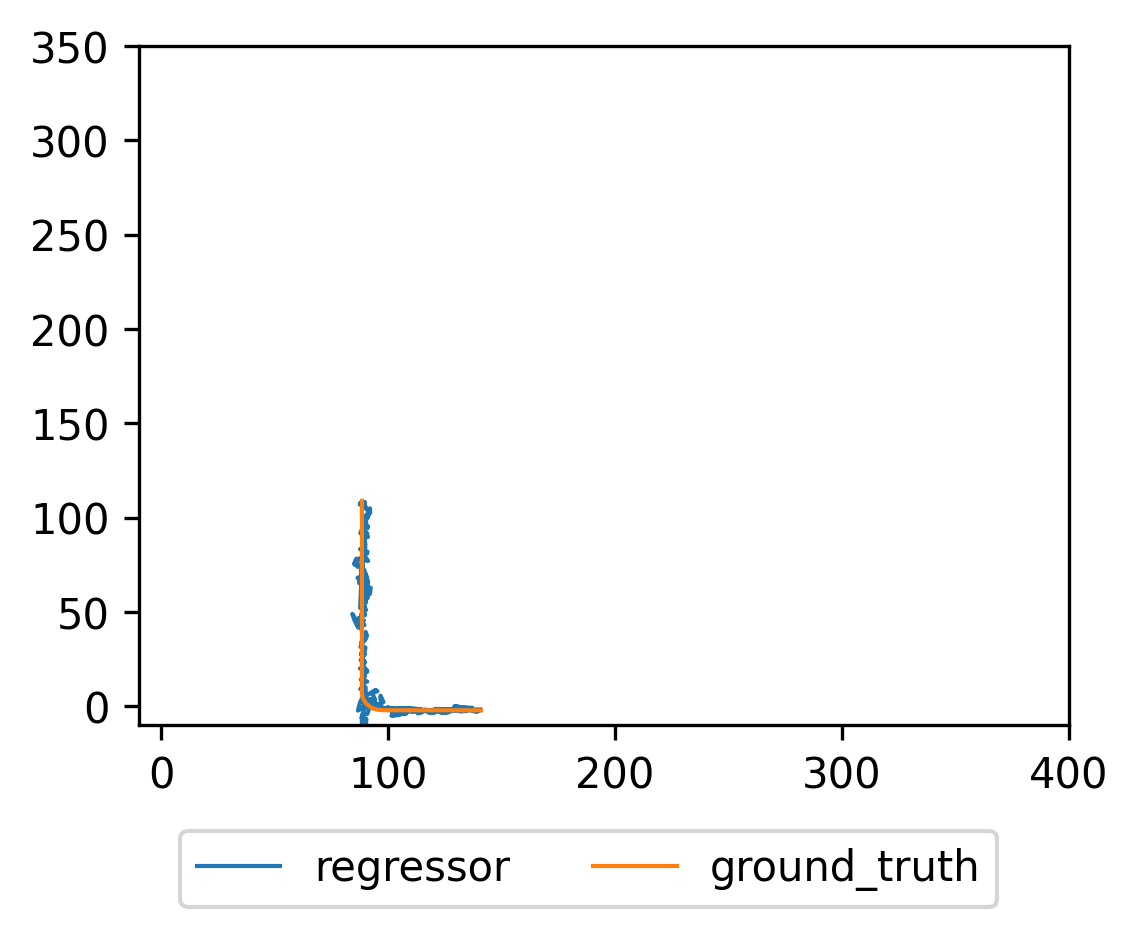

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_445.pt


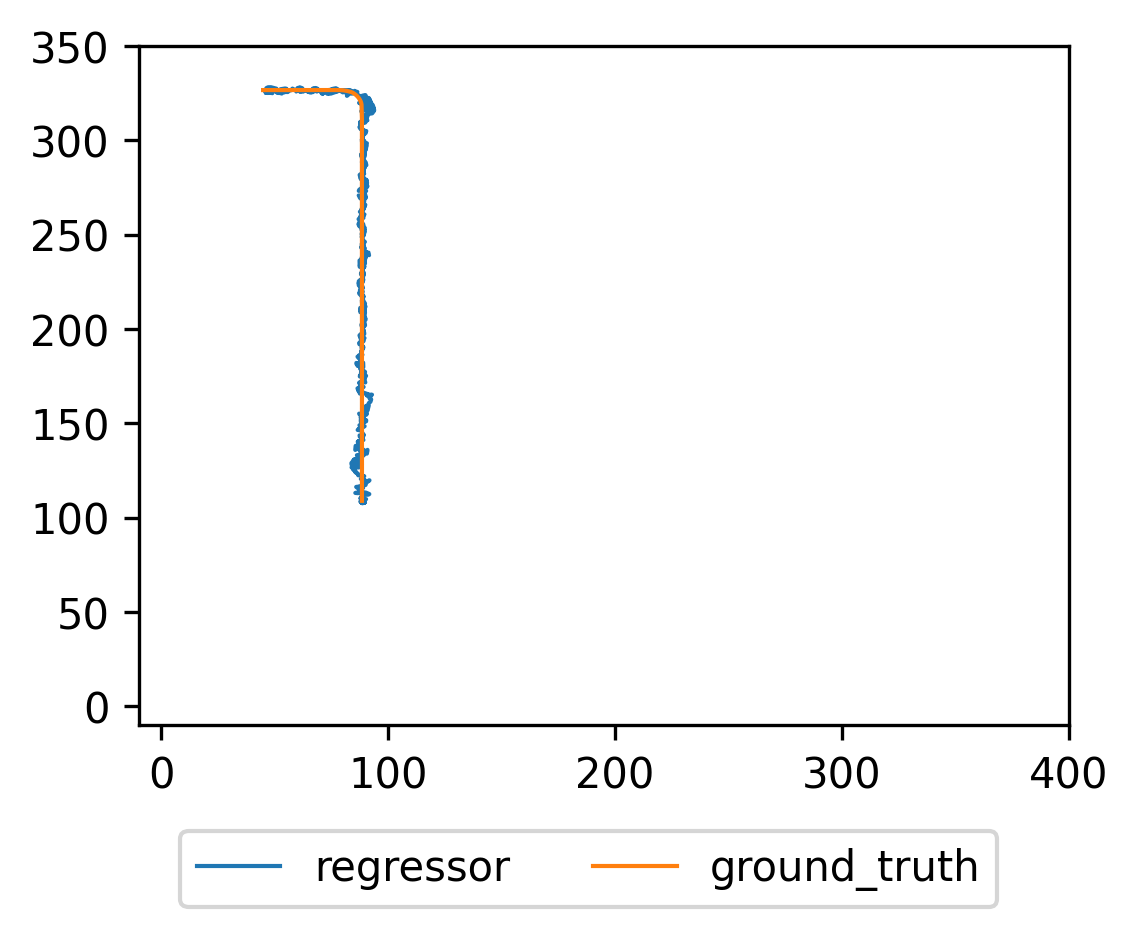

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_446.pt


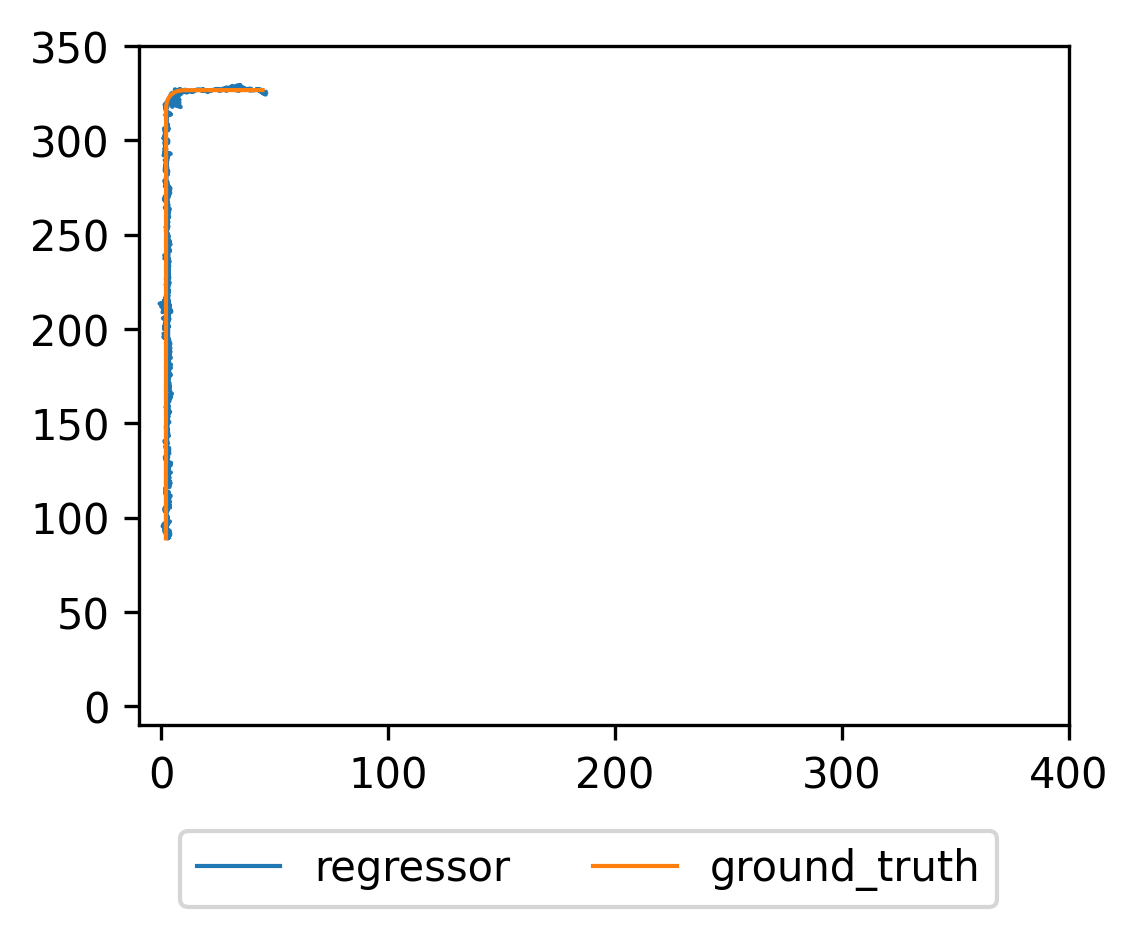

/ubc/cs/research/plai-scratch/video-diffusion-shared/datasets/carla-no-traffic/video_447.pt


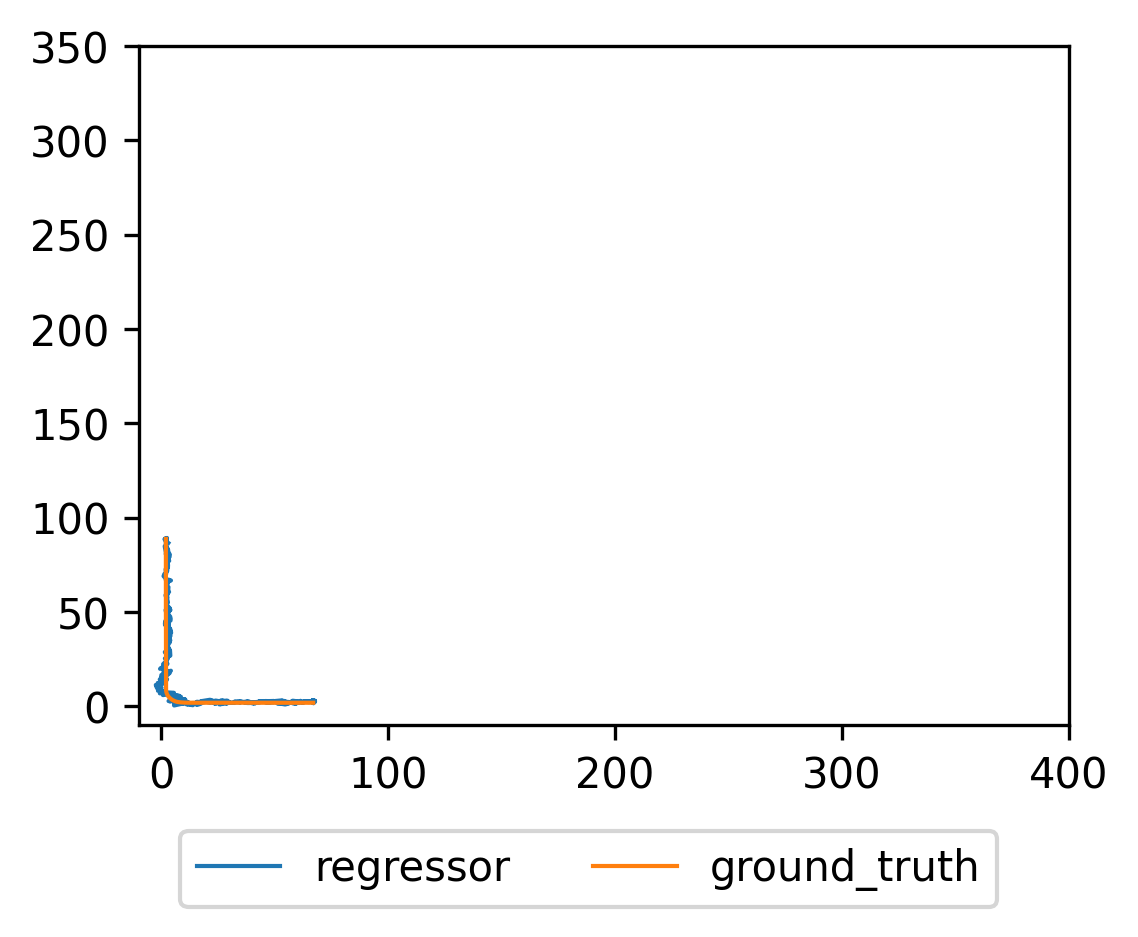

In [116]:
for i in range(20):
    path = df.iloc[i,0]
    out, gt = predict_trajectory(path)
    k = path.split('/')[-1]
    plot_trajectory(out, gt, k)